# KET-VR5 Complete Subgraph Colocalization
### Jonathan Ramos 3/7/2024
In my previous notebook I combed through the adjacency list of coloc groupings once more and this time more strictly assessed whether or not each coloc grouping formed a complete subgraph (in graph theory a complete subgraph refers to set of nodes in a directed graph where every node points to every other node). 

In particular, in the dataframe of amended groupings, I grouped by image_name and roi_id, then took the set union of all identified true coloc groupings. Then, for each roi_id in a given true coloc grouping, I found every other true coloc grouping wehre that roi_id occured and aggregate over the graph loop once more by taking the set union of all of these identified sets. This resulted in the final true grouping. I lastly reassigned all true groupings to each roi_id in a given grouping.

Then after replacing the amended groupings in the full set, I then checked that the number of coloc staintypes is consistent across all members of given coloc stain type. For example, ensuring that the number of PV on WFA cells is equal to the number of WFA on PV cells, for all stain type combinations (32 total: 4 singles, 6 doubles, 12 triples, 4 quads)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import itertools
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

# loading some functions we wrote before
sys.path.append("/Users/jonathanramos/Desktop/LRI/Image ROI Data Wrangling/")
from clean import *
from norm import *
from count import *

sns.set_theme()


# Load in set

In [2]:
df_coloc = pd.read_csv('KET-VR5_FINAL.csv').drop(['Unnamed: 0', 'filename.1', 'dummy'], axis=1)

print(df_coloc.columns)
print(df_coloc.shape)
df_coloc.head()

Index(['index', 'filename', 'image_name', 'roi_id', 'true_grouping',
       'dummy_PV', 'dummy_cFos', 'dummy_Npas4', 'dummy_WFA', 'CoM_x', 'CoM_y',
       'background', 'mean_intensity', 'stain_type', 'rat_n', 'treatment',
       'group_name', 'snr', 'mean-background', 'adjusted_mean-background',
       'true_grouping_literal', 'matching_len', 'updated_true_grouping'],
      dtype='object')
(18632, 23)


,index,filename,image_name,roi_id,true_grouping,dummy_PV,dummy_cFos,dummy_Npas4,dummy_WFA,CoM_x,...,stain_type,rat_n,treatment,group_name,snr,mean-background,adjusted_mean-background,true_grouping_literal,matching_len,updated_true_grouping
0,0,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,0-000-00000_PV,"('0-000-00000_PV', '0-FFF-00045_Npas4', '0-FFF...",True,False,True,True,297.86,...,PV,KET-10-12,FR1_KET,KET-10,2.247372,297.961600,382.72460,"('0-000-00000_PV', '0-FFF-00045_Npas4', '0-FFF...",True,"('0-000-00000_PV', '0-FFF-00045_Npas4', '0-FFF..."
1,1,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,0-000-00001_PV,"('0-000-00001_PV', '0-FFF-00070_cFos', '0-FFF-...",True,True,True,False,340.47,...,PV,KET-10-12,FR1_KET,KET-10,1.318398,76.056290,160.81929,"('0-000-00001_PV', '0-FFF-00070_cFos', '0-FFF-...",True,"('0-000-00001_PV', '0-FFF-00070_cFos', '0-FFF-..."
2,2,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,0-000-00002_PV,"('0-000-00002_PV', '0-FFF-00044_Npas4', '0-FFF...",True,False,True,True,154.85,...,PV,KET-10-12,FR1_KET,KET-10,1.356610,85.184100,169.94710,"('0-000-00002_PV', '0-FFF-00044_Npas4', '0-FFF...",True,"('0-000-00002_PV', '0-FFF-00044_Npas4', '0-FFF..."
3,3,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,0-000-00003_PV,"('0-000-00003_PV', '0-FFF-00082_Npas4', '0-FFF...",True,False,True,True,310.10,...,PV,KET-10-12,FR1_KET,KET-10,1.448608,107.159805,191.92280,"('0-000-00003_PV', '0-FFF-00082_Npas4', '0-FFF...",True,"('0-000-00003_PV', '0-FFF-00082_Npas4', '0-FFF..."
4,4,KET-10-12_PFC_3.7_A_2.tif,KET-10-12_PFC_3.7_A,0-000-00004_PV,"('0-000-00004_PV',)",True,False,False,False,44.35,...,PV,KET-10-12,FR1_KET,KET-10,1.798510,190.741200,275.50420,"('0-000-00004_PV',)",True,"('0-000-00004_PV',)"


# Standard analyses first
our usual normalized intensity and mean cell counts

## Normalize intensity

In [3]:
def normalize_intensity(df, norm_condition, col='mean-background'):
    '''
    computes the mean of rows of the norm_condition and divides mean-background by this mean,
    normalizing all data to the mean of the norm_condition. sets normalized value into new
    column called "norm mean-background" and returns new dataframe containing normalized intensity.
    '''
    df_norm = df[df.treatment == norm_condition]
    norm_mean = df_norm[col].astype('f').mean()

    df_norm = df.copy(deep=True)
    df_norm[f'norm_{col}'] = df[col].astype('f') / norm_mean

    # quickly check that the mean of the norm condition is set to about 1.00000
    # this is never exatly 1 due to small rounding errors from floating point operations
    assert round(df_norm[df_norm.treatment == norm_condition][f'norm_{col}'].mean(), 5) == 1
    
    return df_norm

def prism_reorg(df, col='norm_mean-background'):
    '''
    Takes just the norm_mean-background intensity col per rat, groups by treatment
    and 
    '''
    treatments = np.unique(df.treatment)
    reorg = []

    for t in treatments:
        df_treat = df[df.treatment == t]
        norm_int_ratn = []
        treatment_ratns = np.unique(df_treat.rat_n)

        for rat in treatment_ratns:
            norm_int = df_treat[df_treat.rat_n == rat][col]
            df_normint = pd.DataFrame({t: norm_int}).reset_index(drop=True)
            norm_int_ratn.append(df_normint)

        # concat "vertically"
        df_ratn_cols = pd.concat(norm_int_ratn, axis=0).reset_index(drop=True)

        # write csv to disk
        reorg.append(df_ratn_cols)
    
    # concat "horizontally"
    df_prism_reorg = pd.concat(reorg, axis=1)

    return df_prism_reorg

In [4]:
# we have to do some creative looping to access the nested coloc stain type
# getting every combination of four booleans (position matters)
# except the last one (all False) which would mean the cell had 0 stain types
bool_combs = list(itertools.product([True, False], repeat=4))[:-1]
group = 'KET-VR5'

for bcomb in bool_combs:
    stains = np.array(['PV', 'cFos', 'Npas4', 'WFA'])
    coloc_PV, coloc_cFos, coloc_Npas4, coloc_WFA = [*bcomb]

    q = []
    if coloc_PV:
        q.append(f'dummy_PV == {coloc_PV}')
    if coloc_cFos:
        q.append(f'dummy_cFos == {coloc_cFos}')
    if coloc_Npas4:
        q.append(f'dummy_Npas4 == {coloc_Npas4}')
    if coloc_WFA:
        q.append(f'dummy_WFA == {coloc_WFA}')

    query = ' and '.join(q)
    df_subset = df_coloc.query(query)
    print(len(df_subset), query)

    for stain in df_subset.stain_type.unique():
        self = stain
        stains_filtered = stains.copy()[np.array(bcomb)]
        nonself = np.delete(stains_filtered, np.argwhere(stains_filtered == self))

        df_stain = df_subset.query(f'stain_type == "{self}"')
        
        if len(nonself) == 0:
            coloc_stain_type = f'single_{self}'
        
        if len(nonself) == 1:
            coloc_stain_type = f'{self}_coloc_w_{nonself[0]}'
        
        if len(nonself) == 2:
            coloc_stain_type = f'{self}_coloc_w_{nonself[0]},{nonself[1]}'

        if len(nonself) == 3:
            coloc_stain_type = f'quad_{self}'


        # normalize to FR1_SAL
        df_norm = normalize_intensity(df_stain, norm_condition='FR1_SAL', col='adjusted_mean-background')
        df_norm['coloc_stain_type'] = coloc_stain_type
        df_norm.to_csv(f'{group}_{coloc_stain_type}_NORM.csv')

        # reorganize into cols for prism
        df_prism = prism_reorg(df_norm, col='norm_adjusted_mean-background')
        df_prism.to_csv(f'{group}_{coloc_stain_type}_PRISM.csv')

692 dummy_PV == True and dummy_cFos == True and dummy_Npas4 == True and dummy_WFA == True
1232 dummy_PV == True and dummy_cFos == True and dummy_Npas4 == True
983 dummy_PV == True and dummy_cFos == True and dummy_WFA == True
1767 dummy_PV == True and dummy_cFos == True
929 dummy_PV == True and dummy_Npas4 == True and dummy_WFA == True
1645 dummy_PV == True and dummy_Npas4 == True
1418 dummy_PV == True and dummy_WFA == True
2806 dummy_PV == True
845 dummy_cFos == True and dummy_Npas4 == True and dummy_WFA == True
8261 dummy_cFos == True and dummy_Npas4 == True
1320 dummy_cFos == True and dummy_WFA == True
12826 dummy_cFos == True
1134 dummy_Npas4 == True and dummy_WFA == True
13155 dummy_Npas4 == True
2093 dummy_WFA == True


## Counting mean cell ns

In [5]:
def count_imgs(df, sid, iid):
    '''
    takes a dataframe and counts the number of unique strings that occur in the 
    "image_name" col for each rat in "rat_n" col
    args:
        df: pd.core.frame.DataFrame(n, m) 
            n: the number of rows, 
            m: the number of features
        sid: str, denoting the name of the col containing unique subject ids
        iid: str, denoting the name of the col containing unique image ids
    return:
        df_imgn: pd.core.frame.DataFrame(n=|sid|), m=2)
            n: the number of rows, equal to the cardinality of the sid set
            (the number of unique ID strings in sid)
            this df contains 2 cols: a sid col, and an iid col containing counts
    '''
    assert iid in df.columns

    df_imgn = df.groupby([sid])[[sid, iid]]\
        .apply(lambda x: len(np.unique(x[iid])))\
        .reset_index(name='image_n')
    
    return df_imgn

def count_cells(df, cols):
    '''
    takes a df and counts the number of instances each distinct row 
    (created by unique combinations of labels from columns indicated
    by cols arg); counts are reported in a new col called "cell_counts"
    args:
        df: pd.core.frame.DataFrame(N, M); N: the number of rows, M: the
            number of cols (assumed to have already been split by stain_type)
        cols: list(n), n: the number of cols over which to count distinct rows
    return:
        df_counts: pd.core.frame.DataFrame(N,M+1)
    '''
    df_counts = df.value_counts(cols)\
        .reset_index(name='cell_counts')\
        .sort_values(by=cols)
    
    return df_counts

def sum_cells(df, cols, iid):
    '''
    takes cell count df, groups by cols denoted in cols list and computes sum
    of cell_counts col for each group. Adds new column "cell_count_sums"
    containing sums.
    args:
        df: pd.core.frame.DataFrame(N, M), N: the number of rows (N=|id_col|),
            M: the number of cols, must contain col called "cell_counts"
        cols: list(M-2), list containing col name strings that define each group 
            for group by and reduction (in this case summing)
        iid: str, denotes 
    return:
        df_sums: pd.core.frame.DataFrame; dataframe containing summed cell
            counts per subject id.
    '''
    # remove image id col (we want to sum counts across all images per rat)
    reduce_cols = list(filter(lambda x: x != iid, cols))

    if 'scaled_counts' in df.columns:
            # group by, reduce 
        df_sums = df.groupby(by=reduce_cols)[cols]\
            .apply(lambda x: np.sum(x.scaled_counts))\
            .reset_index(name='cell_count_sums')
    
    else:
        # group by, reduce 
        df_sums = df.groupby(by=reduce_cols)[df.columns]\
            .apply(lambda x: np.sum(x.cell_counts))\
            .reset_index(name='cell_count_sums')
    
    return df_sums

def average_counts(df_sums, df_ns, cols, sid, iid):
    '''
    takes df of cell count sums and df of image ns, and computes the mean cell 
    n (divides cell count sums by the number of images) for each subject.
    args:
        df_sums: pd.core.frame.DataFrame(ni, mi), ni: the number of rows
            (ni=|sid|), mi: the number of cols (mi = |cols|); must 
            contain a col "cell_count_sums". 
        df_ns: pd.core.frame.DataFrame(nj, mj), nj: the number of rows 
            (nj=|sid|), mj: the number of cols (mj=2); must contain a col
            "image_n" 
        cols: list(n), n: the number of cols (contains all cols necessary to 
            create every unique group combination)
        sid: str, denoting the name of the col containing unique subject ids
        iid: str, denoting the name of the col containing unique image ids
    return:
        mean_cell_ns: pd.core.frame.DataFrame(N,M), N: the number of rows (N=
        |sid|), M: the number of cols (M=|cols|+2)
        
    '''
    # list of cols with out image id, since it was removed during the reduction step
    reduce_cols = list(filter(lambda x: x != iid, cols))

    # compute mean cell n
    mean_cell_ns = df_sums.join(df_ns.set_index(sid), on=sid, how='inner')\
        .sort_values(by=reduce_cols)
    mean_cell_ns['mean_cell_n'] = mean_cell_ns.cell_count_sums / mean_cell_ns.image_n

    # reorder so that subject id is the first col
    col_reorder = [sid] + list(filter(lambda x: x != sid, list(mean_cell_ns.columns)))
    mean_cell_ns = mean_cell_ns[col_reorder]

    return mean_cell_ns

def mean_cell_n(df_stain, df_full, cols, sid, iid, return_counts=False):
    '''
    wrapper function to compute mean cell ns; magnification/zoom factor 
    is assuemd to be equal across all images. NOTE that we count total image
    ns based on full cleaned dataset: it may be the case the not every image
    contains every stain type combination, and we must still count images
    with 0 cells of a particular stain type towards the total number of images.
    args:
        df_stain: pd.core.frame.DataFrame; df containing data for a given stain type
        df_full: pd.core.frame.DataFrame; df containing data for full (cleaned) set
        cols: list, contains str denoting col names for grouping
        sid: str, col name denoting col containing unique subject ids
        iid: str, col name denoting col containing unique image ids
        return_counts: bool, flag for added utility during debugging
    return:
        mean_cell_ns: pd.core.frame.DataFrame; df containing final mean cell ns
        cell_counts: pd.core.frame. DataFram; df containing cell counts per
            image (for debugging)
        
    '''
    # count n of unique image names per subject
    img_ns = count_imgs(df_full, sid, iid)

    # count n of cells per image for each subject
    cell_counts = count_cells(df_stain, cols)

    # sum cell counts across all images for each subject
    cell_sums = sum_cells(cell_counts, cols, iid)

    # compute mean cell count per image for each subject
    mean_cell_ns = average_counts(cell_sums, img_ns, cols, sid, iid)

    if not return_counts:
        return mean_cell_ns
    
    return (cell_counts, mean_cell_ns)

In [6]:
# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', sid, iid]
group = 'KET-VR5'

# getting every combination of four booleans (position matters)
# except the last one (all False) which would mean the cell had 0 stain types
bool_combs = list(itertools.product([True, False], repeat=4))[:-1] 

for bcomb in bool_combs:
    # build array of stains
    stains = np.array(['PV', 'cFos', 'Npas4', 'WFA'])

    # unpack booleans
    coloc_PV, coloc_cFos, coloc_Npas4, coloc_WFA = [*bcomb]

    # filter query statements into 
    q = []
    if coloc_PV:
        q.append(f'dummy_PV == {coloc_PV}')
    if coloc_cFos:
        q.append(f'dummy_cFos == {coloc_cFos}')
    if coloc_Npas4:
        q.append(f'dummy_Npas4 == {coloc_Npas4}')
    if coloc_WFA:
        q.append(f'dummy_WFA == {coloc_WFA}')

    # build larger query
    query = ' and '.join(q)
    df_subset = df_coloc.query(query)

    # check len
    print(len(df_subset), query)

    # in the filtered coloc set, analyze each individual stain type
    # for example, if we filter for PV, WFA and cFos, then query this set
    # for all PV cells, we've found all triple labeled PV (PV coloc w WFA and cFos)
    for stain in df_subset.stain_type.unique():
        # keep track of self
        self = stain

        # filter stains arr
        stains_filtered = stains.copy()[np.array(bcomb)]

        # remove self from filtered arr
        nonself = np.delete(stains_filtered, np.argwhere(stains_filtered == self))
        
        # query the coloc subset for a given individual stain
        df_stain = df_subset.query(f'stain_type == "{self}"')
        
        # build coloc_stain_type
        if len(nonself) == 0:
            coloc_stain_type = f'single_{self}'
        
        if len(nonself) == 1:
            coloc_stain_type = f'{self}_coloc_w_{nonself[0]}'
        
        if len(nonself) == 2:
            coloc_stain_type = f'{self}_coloc_w_{nonself[0]},{nonself[1]}'

        if len(nonself) == 3:
            coloc_stain_type = f'quad_{self}'

        # compute mean cell ns
        df_means = mean_cell_n(df_stain, df_coloc, cols, sid, iid)
        df_means['coloc_stain_type'] = coloc_stain_type

        # write to disk
        df_means.to_csv(f'{group}_{coloc_stain_type}_mean_cell_ns.csv')

692 dummy_PV == True and dummy_cFos == True and dummy_Npas4 == True and dummy_WFA == True
1232 dummy_PV == True and dummy_cFos == True and dummy_Npas4 == True
983 dummy_PV == True and dummy_cFos == True and dummy_WFA == True
1767 dummy_PV == True and dummy_cFos == True
929 dummy_PV == True and dummy_Npas4 == True and dummy_WFA == True
1645 dummy_PV == True and dummy_Npas4 == True
1418 dummy_PV == True and dummy_WFA == True
2806 dummy_PV == True
845 dummy_cFos == True and dummy_Npas4 == True and dummy_WFA == True
8261 dummy_cFos == True and dummy_Npas4 == True
1320 dummy_cFos == True and dummy_WFA == True
12826 dummy_cFos == True
1134 dummy_Npas4 == True and dummy_WFA == True
13155 dummy_Npas4 == True
2093 dummy_WFA == True


# Finally getting to the good stuff
Now that our dataset is clean and has all the features we need, we can finally start digging into the questions we are interested in.
Specifically:
- Does treatment/react change the distribution (ratio) of high/low intensity cFos in triple labled cFos/PV/WFA cells?
    - is PV/WFA intensity different in high/low intensity cFos?
- Does treatment/react change the distribution (ratio) of high/low intensity Npas4 in triple labled Npas4/PV/WFA cells?
    - is PV/WFA intensity different in high/low intensity cFos?
- Does cFos intensity differ betwween PV vs Non-PV cells?
- Does Npas4 intensity differ between PV vs Non-PV cells?
- Is Npas4/cFos intentensiy different in PV cells with vs without WFA? 

# Binned cFos
## High/Low cFos counts by treatment/react

                     count       mean        std    min   25%   50%   75%  \
treatment cfos_bin                                                          
FR1_KET   cfos_high    5.0  37.070000  16.578435  11.75  30.0  41.8  49.6   
FR1_SAL   cfos_high    7.0  33.257143  20.445607   6.60  18.9  27.2  52.5   
VR5_KET   cfos_high    5.0  36.000000  16.110245  18.40  21.4  39.2  44.0   
VR5_SAL   cfos_high    6.0  35.466667  21.903303  13.40  20.2  27.3  54.2   

                      max  
treatment cfos_bin         
FR1_KET   cfos_high  52.2  
FR1_SAL   cfos_high  56.2  
VR5_KET   cfos_high  57.0  
VR5_SAL   cfos_high  63.8  
                    count       mean        std    min   25%   50%   75%   max
treatment cfos_bin                                                            
FR1_KET   cfos_low    5.0  40.290000  10.959950  30.25  30.6  40.8  42.8  57.0
FR1_SAL   cfos_low    7.0  35.085714   7.407075  26.80  29.5  34.8  39.6  45.8
VR5_KET   cfos_low    5.0  37.320000   9.770977  27.0

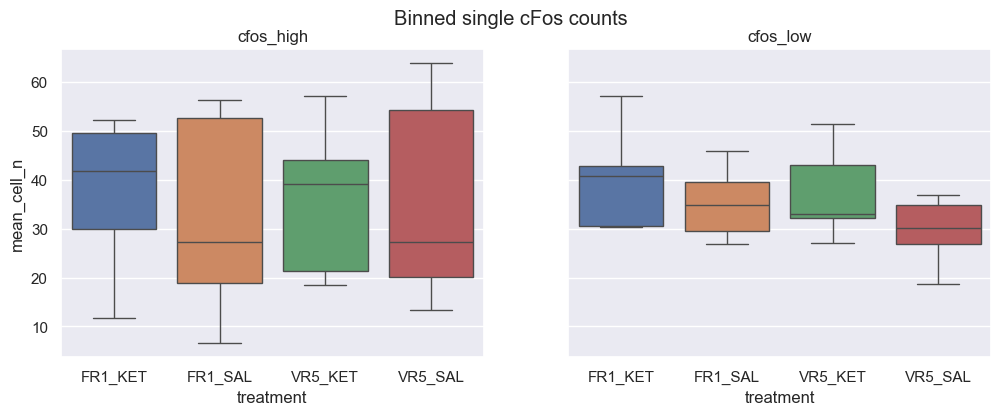

In [7]:
df_cfos = df_coloc.query('stain_type == "cFos"').copy(deep=True).drop('index', axis=1).reset_index()

# build cfos bin label 
cfos_median = df_cfos['adjusted_mean-background'].median()
df_cfos['cfos_bin'] = df_cfos['adjusted_mean-background'].apply(lambda x: 'cfos_high' if x > cfos_median else 'cfos_low')
df_cfos = df_cfos.sort_values(by='cfos_bin')

# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', 'cfos_bin', sid, iid]
group = 'KET-VR5'

f, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
f.suptitle('Binned single cFos counts')

# wrapper fn calls
for i, stain in enumerate(df_cfos.cfos_bin.unique()):
    
    # split by stain type
    df_stain = df_cfos[df_cfos.cfos_bin == stain]

    # compute mean cell ns
    df_means = mean_cell_n(df_stain, df_cfos, cols, sid, iid)

    # write to disk
    df_means.to_csv(f'{group}_{stain}_mean_cell_ns.csv')
    df_means.groupby(['treatment', 'cfos_bin'])['mean_cell_n'].describe().to_csv(f'{group}_{stain}_mean_cell_ns_descriptive_stats.csv')

    # let's just try and get some intuition about these data
    print(df_means.groupby(['treatment', 'cfos_bin'])['mean_cell_n'].describe())

    sns.boxplot(x='treatment', y='mean_cell_n', data=df_means, hue='treatment', ax=axs[i])
    axs[i].set_title(stain)


## High/low cFos counts in only triple PV/WFA/cFos by treatment/react

                     count      mean       std  min   25%  50%   75%   max
treatment cfos_bin                                                        
FR1_KET   cfos_high    5.0  1.330000  0.499500  1.0  1.00  1.2  1.25  2.20
FR1_SAL   cfos_high    7.0  1.057143  0.427618  0.6  0.80  0.8  1.30  1.80
VR5_KET   cfos_high    5.0  1.370000  1.102044  0.6  0.60  1.0  1.40  3.25
VR5_SAL   cfos_high    6.0  1.200000  0.456070  0.8  0.85  1.1  1.35  2.00
                    count    mean       std   min     25%    50%  75%  max
treatment cfos_bin                                                        
FR1_KET   cfos_low    5.0  1.3100  0.765180  0.75  0.8000  1.000  1.4  2.6
FR1_SAL   cfos_low    7.0  1.2000  0.326599  0.80  1.0000  1.000  1.5  1.6
VR5_KET   cfos_low    4.0  1.5125  0.614241  0.80  1.1375  1.525  1.9  2.2
VR5_SAL   cfos_low    5.0  1.2400  0.433590  1.00  1.0000  1.000  1.2  2.0


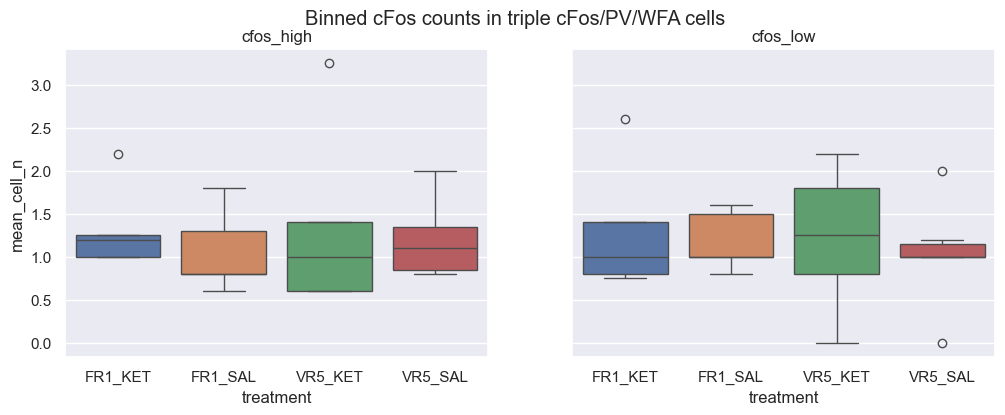

In [8]:
# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', 'cfos_bin', sid, iid]
group = 'KET-VR5'

q = df_cfos.query('dummy_PV == True and dummy_cFos == True and dummy_WFA == True')

df_cfos_image_ns = pd.DataFrame({
    'rat_n': ['KET-10-12','KET-9-1','PE-12-1','PE-12-2','PE-12-7','KET-10-1','KET-10-5','KET-8-2','KET-9-2','KET-9-4','KET-9-5','KET-9-6','KET-10-14','KET-8-7','PE-13-2','PE-13-3','PE-13-6','KET-10-2','KET-10-3','KET-10-4','PE-13-1','PE-13-11','PE-13-9'],
    'treatment': ['FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL'],
    'image_n': [5,4,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5,5,5,5,5,5,5]
})

f, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
f.suptitle('Binned cFos counts in triple cFos/PV/WFA cells')

# wrapper fn calls
for i, stain in enumerate(q.cfos_bin.unique()):
    
    # split by stain type
    df_stain = q[q.cfos_bin == stain]

    # compute mean cell ns
    df_means = mean_cell_n(df_stain, q, cols, sid, iid)

    # ##### not every image had a triple PV/WFA/cFos high/low cFos cell observed
    # ##### and so here I will be building a new image_n col by hand and recalculating means.
    df_means = df_cfos_image_ns.merge(df_means, how='left', on=['rat_n', 'treatment'])
    df_means['image_n'] = df_means.image_n_x
    df_means = df_means.drop(['image_n_x', 'image_n_y', 'mean_cell_n'], axis=1)
    df_means['cell_count_sums'] = df_means.cell_count_sums.fillna(0).astype(int)
    df_means['mean_cell_n'] = df_means.cell_count_sums / df_means.image_n

    # write to disk
    df_means.to_csv(f'{group}_{stain}_triple_cFos_coloc_w_PV,WFA_mean_cell_ns.csv')
    df_means.groupby(['treatment', 'cfos_bin'])['mean_cell_n'].describe().to_csv(f'{group}_{stain}_triple_cFos_coloc_w_PV,WFA_mean_cell_ns_descriptive_stats.csv')

    # let's just try and get some intuition about these data
    print(df_means.groupby(['treatment', 'cfos_bin'])['mean_cell_n'].describe())

    sns.boxplot(x='treatment', y='mean_cell_n', data=df_means, hue='treatment', ax=axs[i])
    axs[i].set_title(stain)

## High/low cFos counts in only double cFos/WFA by treatment/react

                     count      mean       std  min   25%   50%  75%  max
treatment cfos_bin                                                       
FR1_KET   cfos_high    5.0  1.750000  0.712390  1.0  1.20  1.75  2.0  2.8
FR1_SAL   cfos_high    7.0  2.142857  0.950188  1.2  1.40  1.80  2.8  3.6
VR5_KET   cfos_high    5.0  2.020000  0.843801  1.4  1.60  1.80  1.8  3.5
VR5_SAL   cfos_high    6.0  1.666667  0.484424  1.0  1.45  1.60  1.9  2.4
                    count      mean       std   min   25%  50%  75%  max
treatment cfos_bin                                                      
FR1_KET   cfos_low    5.0  1.970000  0.670448  1.25  1.60  1.8  2.2  3.0
FR1_SAL   cfos_low    7.0  1.857143  0.538074  1.20  1.50  1.8  2.2  2.6
VR5_KET   cfos_low    5.0  1.740000  0.915423  0.80  1.00  1.5  2.6  2.8
VR5_SAL   cfos_low    6.0  1.466667  0.546504  1.00  1.05  1.3  1.7  2.4


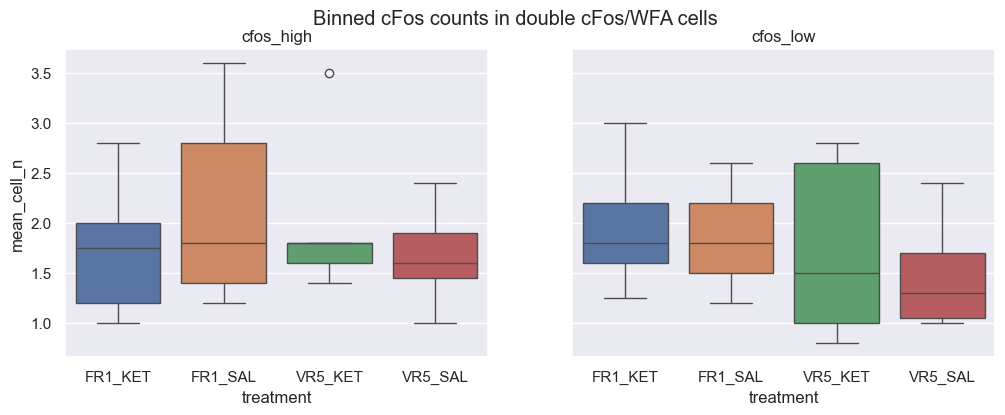

In [9]:
# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', 'cfos_bin', sid, iid]
group = 'KET-VR5'

q = df_cfos.query('dummy_cFos == True and dummy_WFA == True')

df_cfos_image_ns = pd.DataFrame({
    'rat_n': ['KET-10-12','KET-9-1','PE-12-1','PE-12-2','PE-12-7','KET-10-1','KET-10-5','KET-8-2','KET-9-2','KET-9-4','KET-9-5','KET-9-6','KET-10-14','KET-8-7','PE-13-2','PE-13-3','PE-13-6','KET-10-2','KET-10-3','KET-10-4','PE-13-1','PE-13-11','PE-13-9'],
    'treatment': ['FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL'],
    'image_n': [5,4,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5,5,5,5,5,5,5]
})

f, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
f.suptitle('Binned cFos counts in double cFos/WFA cells')

# wrapper fn calls
for i, stain in enumerate(q.cfos_bin.unique()):
    
    # split by stain type
    df_stain = q[q.cfos_bin == stain]

    # compute mean cell ns
    df_means = mean_cell_n(df_stain, q, cols, sid, iid)

    # ##### not every image had a triple PV/WFA/cFos high/low cFos cell observed
    # ##### and so here I will be building a new image_n col by hand and recalculating means.
    df_means = df_cfos_image_ns.merge(df_means, how='left', on=['rat_n', 'treatment'])
    df_means['image_n'] = df_means.image_n_x
    df_means = df_means.drop(['image_n_x', 'image_n_y', 'mean_cell_n'], axis=1)
    df_means['cell_count_sums'] = df_means.cell_count_sums.fillna(0).astype(int)
    df_means['mean_cell_n'] = df_means.cell_count_sums / df_means.image_n

    # write to disk
    df_means.to_csv(f'{group}_{stain}_double_cfos_coloc_w_WFA_mean_cell_ns.csv')
    df_means.groupby(['treatment', 'cfos_bin'])['mean_cell_n'].describe().to_csv(f'{group}_{stain}_double_cfos_coloc_w_WFA_mean_cell_ns_descriptive_stats.csv')

    # let's just try and get some intuition about these data
    print(df_means.groupby(['treatment', 'cfos_bin'])['mean_cell_n'].describe())

    sns.boxplot(x='treatment', y='mean_cell_n', data=df_means, hue='treatment', ax=axs[i])
    axs[i].set_title(stain)

## High/low cFos counts in only double cFos/PV by treatment/react

                     count      mean       std   min  25%  50%   75%   max
treatment cfos_bin                                                        
FR1_KET   cfos_high    5.0  2.450000  1.165118  1.25  1.8  1.8  3.60   3.8
FR1_SAL   cfos_high    7.0  2.371429  0.582278  1.20  2.3  2.4  2.70   3.0
VR5_KET   cfos_high    5.0  3.340000  4.058078  0.80  1.0  2.0  2.40  10.5
VR5_SAL   cfos_high    6.0  3.166667  1.689576  1.20  2.0  2.8  4.65   5.2
                    count  mean       std  min   25%  50%  75%   max
treatment cfos_bin                                                  
FR1_KET   cfos_low    5.0  2.47  1.322687  1.2  1.75  2.0  2.8  4.60
FR1_SAL   cfos_low    7.0  2.40  0.553775  2.0  2.10  2.2  2.4  3.60
VR5_KET   cfos_low    5.0  2.41  1.607949  0.4  1.20  2.6  3.6  4.25
VR5_SAL   cfos_low    5.0  2.44  0.517687  2.0  2.00  2.2  3.0  3.00


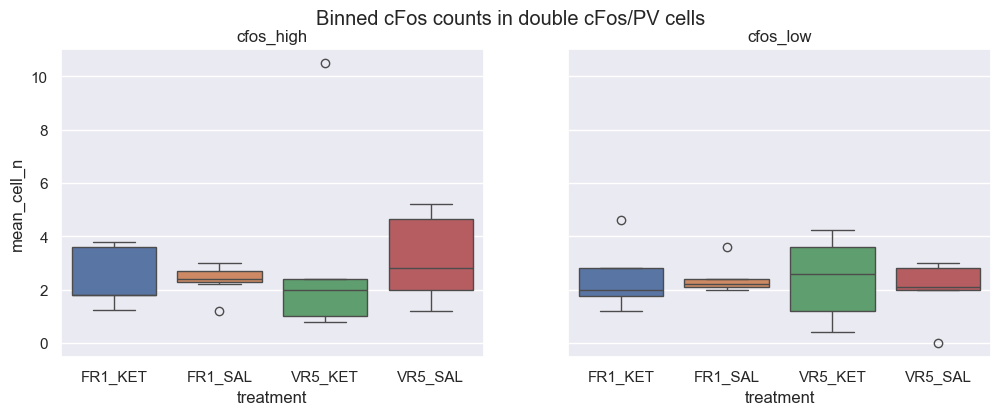

In [10]:
# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', 'cfos_bin', sid, iid]
group = 'KET-VR5'

q = df_cfos.query('dummy_PV == True and dummy_cFos == True')

df_cfos_image_ns = pd.DataFrame({
    'rat_n': ['KET-10-12','KET-9-1','PE-12-1','PE-12-2','PE-12-7','KET-10-1','KET-10-5','KET-8-2','KET-9-2','KET-9-4','KET-9-5','KET-9-6','KET-10-14','KET-8-7','PE-13-2','PE-13-3','PE-13-6','KET-10-2','KET-10-3','KET-10-4','PE-13-1','PE-13-11','PE-13-9'],
    'treatment': ['FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL'],
    'image_n': [5,4,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5,5,5,5,5,5,5]
})


f, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
f.suptitle('Binned cFos counts in double cFos/PV cells')

# wrapper fn calls
for i, stain in enumerate(q.cfos_bin.unique()):
    
    # split by stain type
    df_stain = q[q.cfos_bin == stain]

    # compute mean cell ns
    df_means = mean_cell_n(df_stain, q, cols, sid, iid)

    # ##### not every image had a triple PV/WFA/cFos high/low cFos cell observed
    # ##### and so here I will be building a new image_n col by hand and recalculating means.
    df_means = df_cfos_image_ns.merge(df_means, how='left', on=['rat_n', 'treatment'])
    df_means['image_n'] = df_means.image_n_x
    df_means = df_means.drop(['image_n_x', 'image_n_y', 'mean_cell_n'], axis=1)
    df_means['cell_count_sums'] = df_means.cell_count_sums.fillna(0).astype(int)
    df_means['mean_cell_n'] = df_means.cell_count_sums / df_means.image_n

    # write to disk
    df_means.to_csv(f'{group}_{stain}_double_cfos_coloc_w_PV_mean_cell_ns.csv')
    df_means.groupby(['treatment', 'cfos_bin'])['mean_cell_n'].describe().to_csv(f'{group}_{stain}_double_cfos_coloc_w_PV_mean_cell_ns_descriptive_stats.csv')

    # let's just try and get some intuition about these data
    print(df_means.groupby(['treatment', 'cfos_bin'])['mean_cell_n'].describe())

    sns.boxplot(x='treatment', y='mean_cell_n', data=df_means, hue='treatment', ax=axs[i])
    axs[i].set_title(stain)

## High/low Npas4 counts by treatment/react

                     count       mean        std    min   25%   50%   75%  \
treatment Npas4_bin                                                         
FR1_KET   Npas4_low    5.0  46.470000  21.805148  10.75  42.8  52.8  59.4   
FR1_SAL   Npas4_low    7.0  20.600000  17.360876   1.40   9.3  18.4  27.8   
VR5_KET   Npas4_low    5.0  44.220000   6.661231  36.80  37.4  47.2  48.5   
VR5_SAL   Npas4_low    6.0  43.433333  14.703696  21.60  34.2  47.6  51.4   

                      max  
treatment Npas4_bin        
FR1_KET   Npas4_low  66.6  
FR1_SAL   Npas4_low  50.2  
VR5_KET   Npas4_low  51.2  
VR5_SAL   Npas4_low  61.4  
                      count       mean        std   min    25%   50%    75%  \
treatment Npas4_bin                                                           
FR1_KET   Npas4_high    5.0  23.410000   6.228603  14.0  22.80  23.4  25.60   
FR1_SAL   Npas4_high    7.0  55.914286  18.076451  26.4  47.40  57.6  64.70   
VR5_KET   Npas4_high    5.0  32.490000  27.320514  11

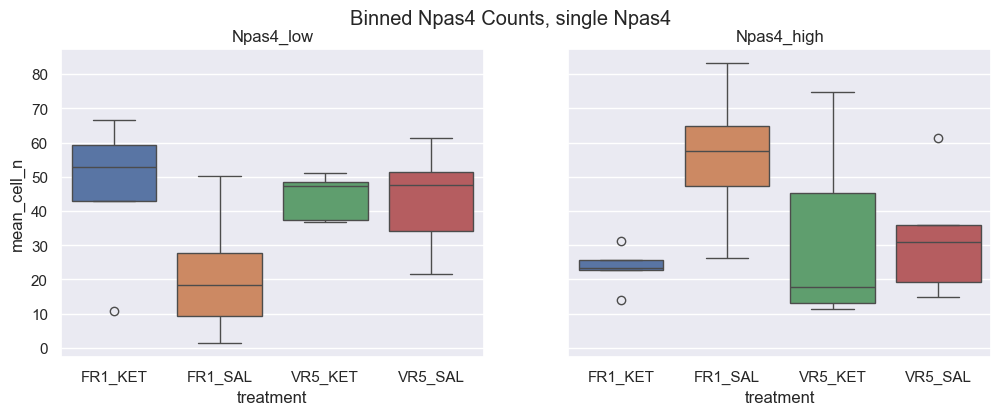

In [11]:
df_Npas4 = df_coloc.query('stain_type == "Npas4"').copy(deep=True).drop('index', axis=1).reset_index()
sns.set_theme()

# build Npas4 bin label 
Npas4_median = df_Npas4['adjusted_mean-background'].median()
df_Npas4['Npas4_bin'] = df_Npas4['adjusted_mean-background'].apply(lambda x: 'Npas4_high' if x > Npas4_median else 'Npas4_low')

# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', 'Npas4_bin', sid, iid]
group = 'KET-VR5'

f, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
f.suptitle('Binned Npas4 Counts, single Npas4')

# wrapper fn calls
for i, stain in enumerate(df_Npas4.Npas4_bin.unique()):
    
    # split by stain type
    df_stain = df_Npas4[df_Npas4.Npas4_bin == stain]

    # compute mean cell ns
    df_means = mean_cell_n(df_stain, df_Npas4, cols, sid, iid)

    # write to disk
    df_means.to_csv(f'{group}_{stain}_mean_cell_ns.csv')
    df_means.groupby(['treatment', 'Npas4_bin'])['mean_cell_n'].describe().to_csv(f'{group}_{stain}_mean_cell_ns_descriptive_stats.csv')

    # let's just try and get some intuition about these data
    print(df_means.groupby(['treatment', 'Npas4_bin'])['mean_cell_n'].describe())

    sns.boxplot(x='treatment', y='mean_cell_n', data=df_means, hue='treatment', ax=axs[i])
    axs[i].set_title(stain)

## High/low Npas4 counts in only triple Npas4/PV/WFA cells by treatment/react

                      count      mean       std  min   25%  50%   75%  max
treatment Npas4_bin                                                       
FR1_KET   Npas4_high    5.0  1.340000  0.779744  0.4  1.00  1.2  1.60  2.5
FR1_SAL   Npas4_high    7.0  1.885714  0.798809  1.2  1.50  1.6  1.90  3.6
VR5_KET   Npas4_high    5.0  0.800000  0.547723  0.2  0.40  0.8  1.00  1.6
VR5_SAL   Npas4_high    4.0  1.200000  0.673300  0.4  0.85  1.2  1.55  2.0
                     count  mean       std   min   25%   50%   75%  max
treatment Npas4_bin                                                    
FR1_KET   Npas4_low    5.0  1.17  0.724224  0.25  0.60  1.40  1.60  2.0
FR1_SAL   Npas4_low    6.0  0.70  0.374166  0.20  0.45  0.70  0.95  1.2
VR5_KET   Npas4_low    5.0  1.21  0.600417  0.60  0.60  1.25  1.80  1.8
VR5_SAL   Npas4_low    6.0  1.10  0.547723  0.40  0.70  1.10  1.50  1.8


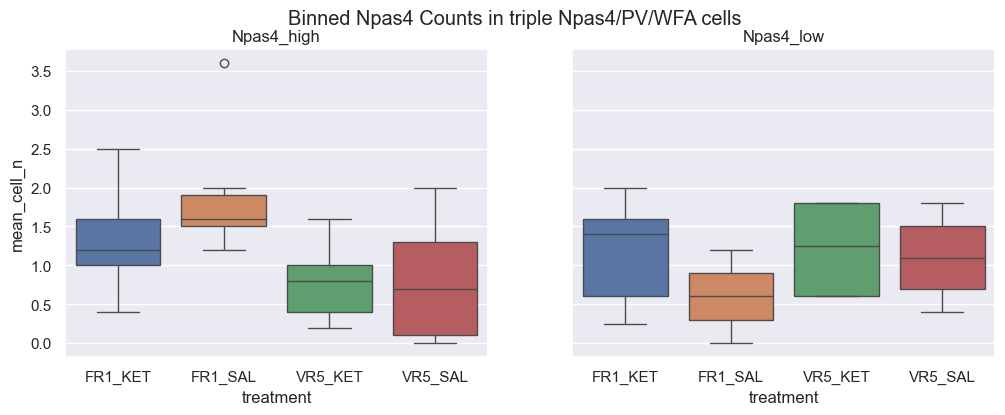

In [12]:
# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', 'Npas4_bin', sid, iid]
group = 'KET-VR5'

q = df_Npas4.query('dummy_PV == True and dummy_Npas4 == True and dummy_WFA == True')

df_Npas4_image_ns = pd.DataFrame({
    'rat_n': ['KET-10-12','KET-9-1','PE-12-1','PE-12-2','PE-12-7','KET-10-1','KET-10-5','KET-8-2','KET-9-2','KET-9-4','KET-9-5','KET-9-6','KET-10-14','KET-8-7','PE-13-2','PE-13-3','PE-13-6','KET-10-2','KET-10-3','KET-10-4','PE-13-1','PE-13-11','PE-13-9'],
    'treatment': ['FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL'],
    'image_n': [5,4,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5,5,5,5,5,5,5]
})

f, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
f.suptitle('Binned Npas4 Counts in triple Npas4/PV/WFA cells')

# wrapper fn calls
for i, stain in enumerate(q.Npas4_bin.unique()):
    
    # split by stain type
    df_stain = q[q.Npas4_bin == stain]

    # compute mean cell ns
    df_means = mean_cell_n(df_stain, q, cols, sid, iid)

    # ##### not every image had a triple PV/WFA/Npas4 high/low Npas4 cell observed
    # ##### and so here I will be building a new image_n col by hand and recalculating means.
    df_means = df_Npas4_image_ns.merge(df_means, how='left', on=['rat_n', 'treatment'])
    df_means['image_n'] = df_means.image_n_x
    df_means = df_means.drop(['image_n_x', 'image_n_y', 'mean_cell_n'], axis=1)
    df_means['cell_count_sums'] = df_means.cell_count_sums.fillna(0).astype(int)
    df_means['mean_cell_n'] = df_means.cell_count_sums / df_means.image_n

    # write to disk
    df_means.to_csv(f'{group}_{stain}_triple_Npas4_coloc_w_PV,WFA_mean_cell_ns.csv')
    df_means.groupby(['treatment', 'Npas4_bin'])['mean_cell_n'].describe().to_csv(f'{group}_{stain}_triple_Npas4_coloc_w_PV,WFA_mean_cell_ns_descriptive_stats.csv')

    # let's just try and get some intuition about these data
    print(df_means.groupby(['treatment', 'Npas4_bin'])['mean_cell_n'].describe())

    sns.boxplot(x='treatment', y='mean_cell_n', data=df_means, hue='treatment', ax=axs[i])
    axs[i].set_title(stain)

## High/low Npas4 counts in only double Npas4/WFA cells by treatment/react

                      count      mean       std  min  25%  50%   75%   max
treatment Npas4_bin                                                       
FR1_KET   Npas4_high    5.0  1.690000  0.964624  0.6  1.4  1.6  1.60  3.25
FR1_SAL   Npas4_high    7.0  2.714286  0.965105  1.4  1.9  3.0  3.50  3.80
VR5_KET   Npas4_high    5.0  0.930000  0.616036  0.2  0.6  0.8  1.25  1.80
VR5_SAL   Npas4_high    5.0  1.160000  0.817313  0.2  0.4  1.4  1.80  2.00
                     count      mean       std  min   25%   50%   75%  max
treatment Npas4_bin                                                       
FR1_KET   Npas4_low    5.0  1.540000  0.859069  0.5  1.00  1.40  2.20  2.6
FR1_SAL   Npas4_low    6.0  0.866667  0.393277  0.2  0.70  1.00  1.15  1.2
VR5_KET   Npas4_low    5.0  1.650000  0.785812  1.0  1.00  1.25  2.40  2.6
VR5_SAL   Npas4_low    6.0  1.333333  0.575036  0.6  1.05  1.20  1.65  2.2


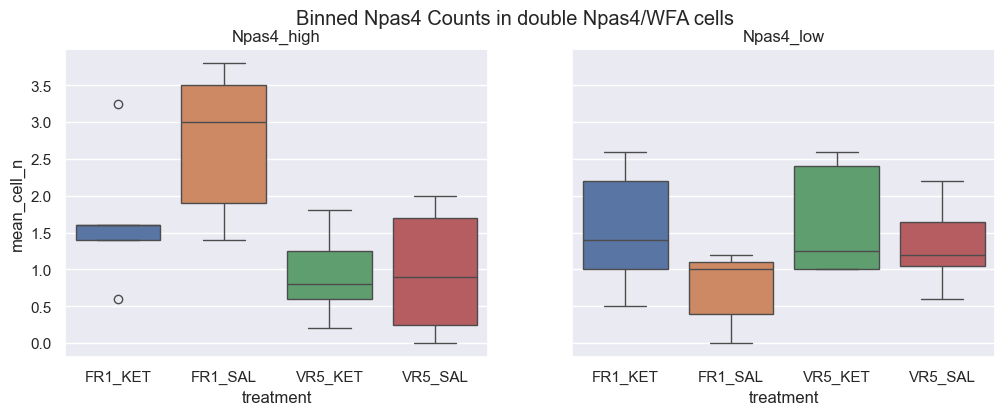

In [13]:
# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', 'Npas4_bin', sid, iid]
group = 'KET-VR5'

q = df_Npas4.query('dummy_Npas4 == True and dummy_WFA == True')

df_Npas4_image_ns = pd.DataFrame({
    'rat_n': ['KET-10-12','KET-9-1','PE-12-1','PE-12-2','PE-12-7','KET-10-1','KET-10-5','KET-8-2','KET-9-2','KET-9-4','KET-9-5','KET-9-6','KET-10-14','KET-8-7','PE-13-2','PE-13-3','PE-13-6','KET-10-2','KET-10-3','KET-10-4','PE-13-1','PE-13-11','PE-13-9'],
    'treatment': ['FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL'],
    'image_n': [5,4,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5,5,5,5,5,5,5]
})

f, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
f.suptitle('Binned Npas4 Counts in double Npas4/WFA cells')

# wrapper fn calls
for i, stain in enumerate(q.Npas4_bin.unique()):
    
    # split by stain type
    df_stain = q[q.Npas4_bin == stain]

    # compute mean cell ns
    df_means = mean_cell_n(df_stain, q, cols, sid, iid)

    # ##### not every image had a triple PV/WFA/Npas4 high/low Npas4 cell observed
    # ##### and so here I will be building a new image_n col by hand and recalculating means.
    df_means = df_Npas4_image_ns.merge(df_means, how='left', on=['rat_n', 'treatment'])
    df_means['image_n'] = df_means.image_n_x
    df_means = df_means.drop(['image_n_x', 'image_n_y', 'mean_cell_n'], axis=1)
    df_means['cell_count_sums'] = df_means.cell_count_sums.fillna(0).astype(int)
    df_means['mean_cell_n'] = df_means.cell_count_sums / df_means.image_n

    # write to disk
    df_means.to_csv(f'{group}_{stain}_double_Npas4_coloc_w_WFA_mean_cell_ns.csv')
    df_means.groupby(['treatment', 'Npas4_bin'])['mean_cell_n'].describe().to_csv(f'{group}_{stain}_double_Npas4_coloc_w_WFA_mean_cell_ns_descriptive_stats.csv')

    # let's just try and get some intuition about these data
    print(df_means.groupby(['treatment', 'Npas4_bin'])['mean_cell_n'].describe())

    sns.boxplot(x='treatment', y='mean_cell_n', data=df_means, hue='treatment', ax=axs[i])
    axs[i].set_title(stain)

## High/low Npas4 counts in only double Npas4/PV cells by treatment/react

                      count      mean       std  min  25%  50%   75%   max
treatment Npas4_bin                                                       
FR1_KET   Npas4_high    5.0  1.830000  1.139956  1.0  1.2  1.2  2.00  3.75
FR1_SAL   Npas4_high    7.0  3.771429  1.348721  2.4  2.9  3.4  4.20  6.40
VR5_KET   Npas4_high    5.0  2.420000  3.048278  0.2  0.4  1.0  3.00  7.50
VR5_SAL   Npas4_high    6.0  2.433333  2.278303  0.2  0.6  1.9  4.25  5.40
                     count      mean       std   min  25%  50%   75%  max
treatment Npas4_bin                                                      
FR1_KET   Npas4_low    5.0  2.590000  1.656955  0.75  1.8  1.8  3.80  4.8
FR1_SAL   Npas4_low    6.0  1.100000  0.787401  0.20  0.5  1.0  1.65  2.2
VR5_KET   Npas4_low    5.0  2.360000  1.099091  1.20  1.6  2.2  2.80  4.0
VR5_SAL   Npas4_low    6.0  2.266667  1.055778  0.40  2.0  2.5  3.00  3.2


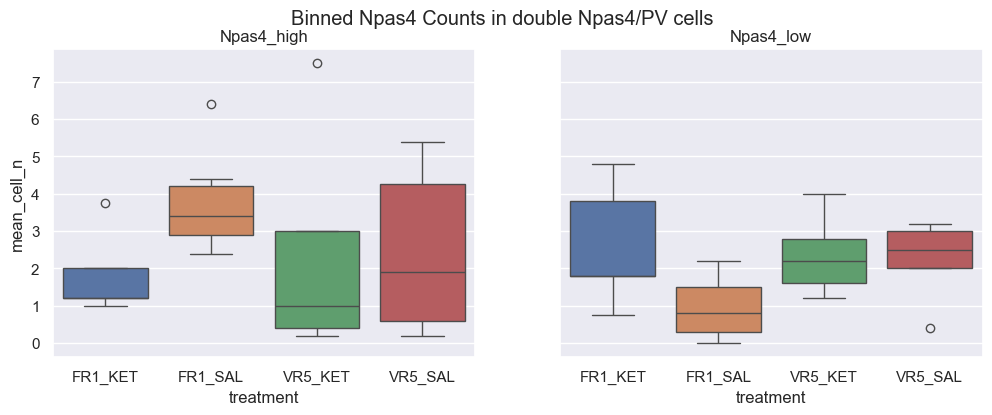

In [14]:
# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', 'Npas4_bin', sid, iid]
group = 'KET-VR5'

q = df_Npas4.query('dummy_Npas4 == True and dummy_PV == True')

df_Npas4_image_ns = pd.DataFrame({
    'rat_n': ['KET-10-12','KET-9-1','PE-12-1','PE-12-2','PE-12-7','KET-10-1','KET-10-5','KET-8-2','KET-9-2','KET-9-4','KET-9-5','KET-9-6','KET-10-14','KET-8-7','PE-13-2','PE-13-3','PE-13-6','KET-10-2','KET-10-3','KET-10-4','PE-13-1','PE-13-11','PE-13-9'],
    'treatment': ['FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_KET','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','FR1_SAL','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_KET','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL','VR5_SAL'],
    'image_n': [5,4,5,5,5,5,5,5,5,5,5,5,5,4,5,5,5,5,5,5,5,5,5]
})

f, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
f.suptitle('Binned Npas4 Counts in double Npas4/PV cells')

# wrapper fn calls
for i, stain in enumerate(q.Npas4_bin.unique()):
    
    # split by stain type
    df_stain = q[q.Npas4_bin == stain]

    # compute mean cell ns
    df_means = mean_cell_n(df_stain, q, cols, sid, iid)

    # ##### not every image had a triple PV/PV/Npas4 high/low Npas4 cell observed
    # ##### and so here I will be building a new image_n col by hand and recalculating means.
    df_means = df_Npas4_image_ns.merge(df_means, how='left', on=['rat_n', 'treatment'])
    df_means['image_n'] = df_means.image_n_x
    df_means = df_means.drop(['image_n_x', 'image_n_y', 'mean_cell_n'], axis=1)
    df_means['cell_count_sums'] = df_means.cell_count_sums.fillna(0).astype(int)
    df_means['mean_cell_n'] = df_means.cell_count_sums / df_means.image_n

    # write to disk
    df_means.to_csv(f'{group}_{stain}_double_Npas4_coloc_w_PV_mean_cell_ns.csv')
    df_means.groupby(['treatment', 'Npas4_bin'])['mean_cell_n'].describe().to_csv(f'{group}_{stain}_double_Npas4_coloc_w_PV_mean_cell_ns_descriptive_stats.csv')

    # let's just try and get some intuition about these data
    print(df_means.groupby(['treatment', 'Npas4_bin'])['mean_cell_n'].describe())

    sns.boxplot(x='treatment', y='mean_cell_n', data=df_means, hue='treatment', ax=axs[i])
    axs[i].set_title(stain)

# Pairwise plots
## if any of these plots look interesting i would get regression lines for each group then probably do like an F-test to see if the linear models are different from each other.

(448, 5)


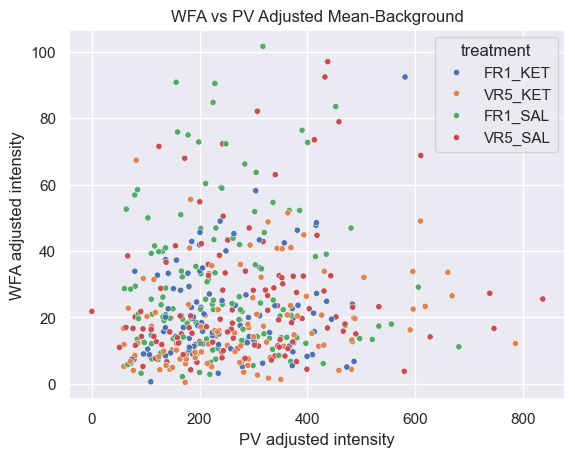

(572, 5)


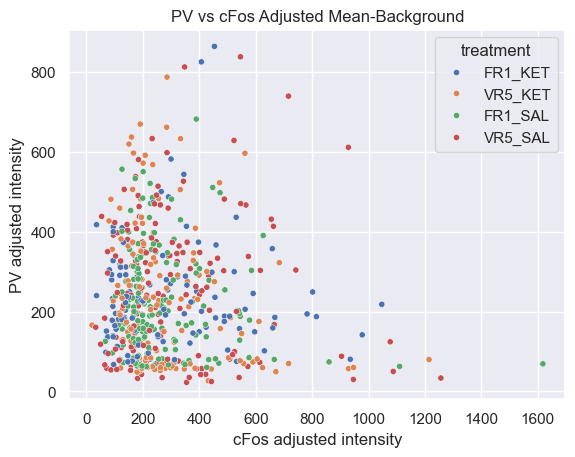

(413, 5)


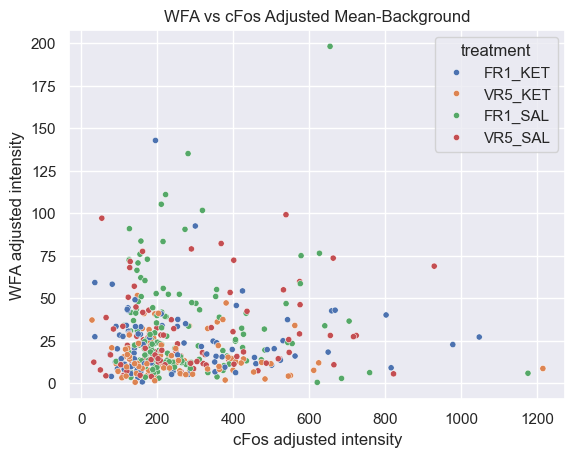

(3842, 5)


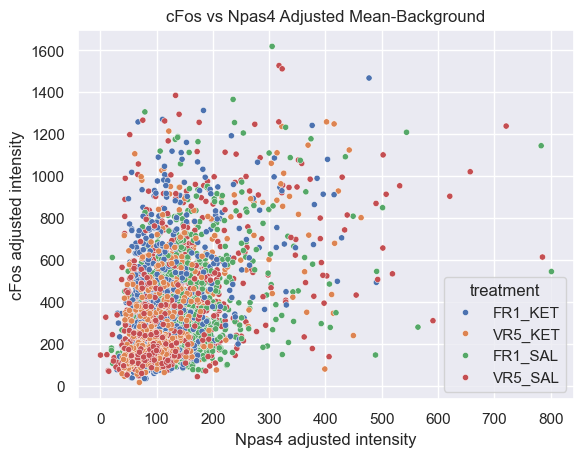

(520, 5)


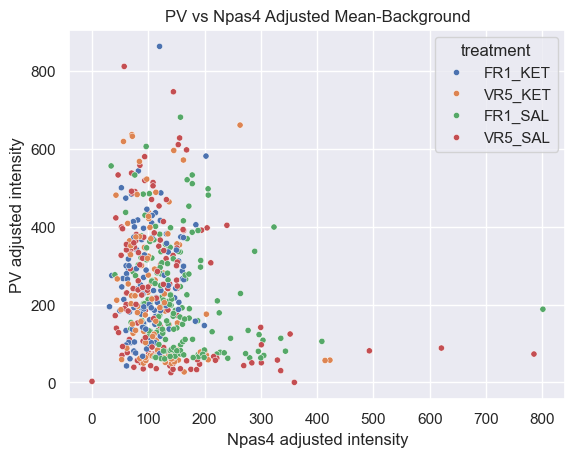

(329, 5)


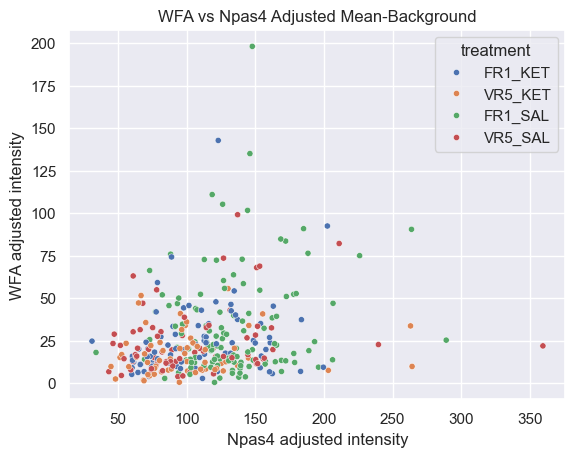

In [15]:
def intensity_scatter_plot(df_data, stain_X, stain_Y, query=False):
    if not query:
        q = df_data.query(f'dummy_{stain_X} == {True} and dummy_{stain_Y} == {True}\
                           and (stain_type == "{stain_X}" or stain_type == "{stain_Y}")')
    elif query:
        q = df_data.query(query)
    df_X = q.query(f'stain_type == "{stain_X}"')[
        ['image_name', 'true_grouping', 'treatment', 'adjusted_mean-background']
        ].rename(columns={'adjusted_mean-background': f'{stain_X} adjusted intensity'})
    df_Y = q.query(f'stain_type == "{stain_Y}"')[
        ['image_name', 'true_grouping', 'treatment', 'adjusted_mean-background']
        ].rename(columns={'adjusted_mean-background': f'{stain_Y} adjusted intensity'})

    df_X['id'] = list(zip(df_X.image_name.values, df_X.true_grouping.values))
    df_Y['id'] = list(zip(df_Y.image_name.values, df_Y.true_grouping.values))

    df_X = df_X.drop(['image_name', 'true_grouping'], axis=1)
    df_Y = df_Y.drop(['image_name', 'true_grouping'], axis=1)

    df_merge = df_X.merge(df_Y, on='id').rename(columns={'treatment_x': 'treatment'})
    print(df_merge.shape)

    sns.set_theme()
    sns.scatterplot(x=f'{stain_X} adjusted intensity', y=f'{stain_Y} adjusted intensity', hue='treatment', data=df_merge, s=20)
    plt.title(f'{stain_Y} vs {stain_X} Adjusted Mean-Background')
    plt.show()

intensity_scatter_plot(df_coloc, 'PV', 'WFA')
intensity_scatter_plot(df_coloc, 'cFos', 'PV')
intensity_scatter_plot(df_coloc, 'cFos', 'WFA')
intensity_scatter_plot(df_coloc, 'Npas4', 'cFos')
intensity_scatter_plot(df_coloc, 'Npas4', 'PV')
intensity_scatter_plot(df_coloc, 'Npas4', 'WFA')

# Linear regressors for double labeled stain types

======= WFA vs PV Adjusted Mean-Background =======
(448, 5)


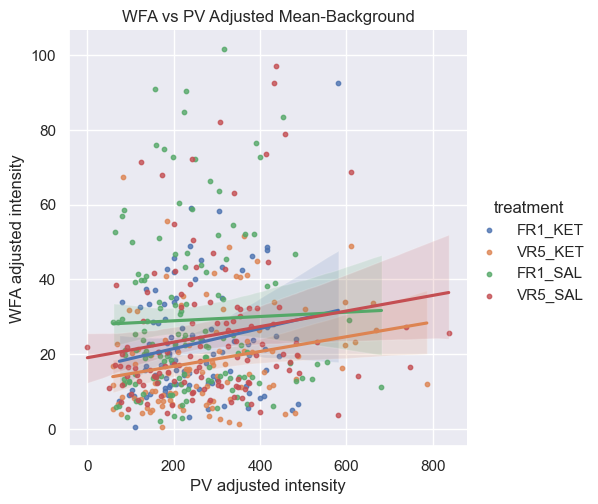

  treatment     slope  intercept   r_value   p_value   std_err sig
0   FR1_KET  0.026852  16.111028  0.193679  0.062862  0.014258    
1   VR5_KET  0.019712  12.829393  0.224354  0.022710  0.008519   *
2   FR1_SAL  0.005738  27.768000  0.032991  0.704046  0.015074    
3   VR5_SAL  0.020818  19.043994  0.164484  0.076369  0.011642    



======= PV vs cFos Adjusted Mean-Background =======
(572, 5)


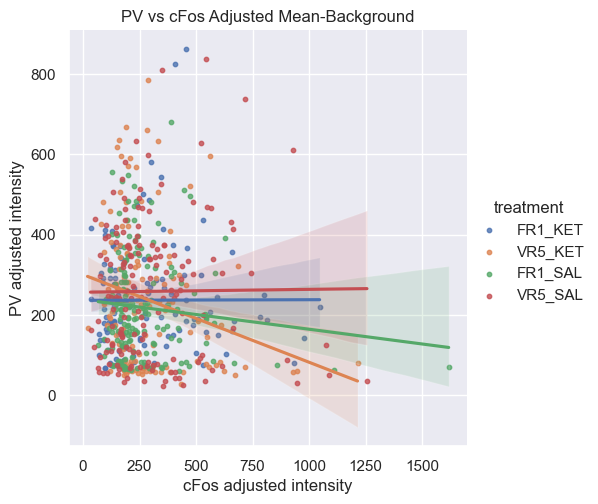

  treatment     slope   intercept   r_value   p_value   std_err sig
0   FR1_KET  0.001506  235.824511  0.002362  0.979577  0.058711    
1   VR5_KET -0.218557  299.892582 -0.228097  0.009327  0.082783   *
2   FR1_SAL -0.073619  237.347297 -0.100512  0.196211  0.056731    
3   VR5_SAL  0.007119  256.070467  0.008746  0.913707  0.065592    



======= WFA vs cFos Adjusted Mean-Background =======
(413, 5)


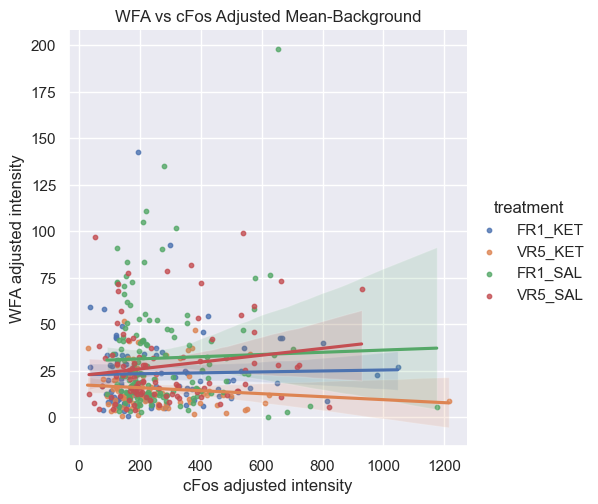

  treatment     slope  intercept   r_value   p_value   std_err sig
0   FR1_KET  0.002515  22.864307  0.026117  0.806965  0.010260    
1   VR5_KET -0.008052  17.485669 -0.118282  0.269602  0.007247    
2   FR1_SAL  0.005933  30.182272  0.032931  0.699304  0.015329    
3   VR5_SAL  0.018440  22.278421  0.158435  0.127213  0.011981    



======= cFos vs Npas4 Adjusted Mean-Background =======
(3842, 5)


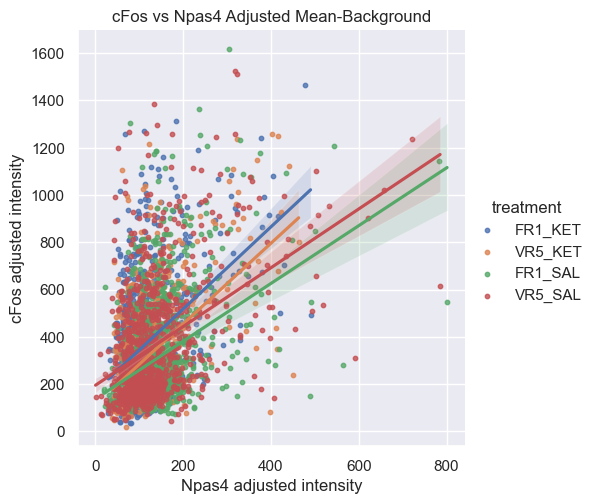

  treatment     slope   intercept   r_value       p_value   std_err sig
0   FR1_KET  1.738664  169.786936  0.430260  8.049359e-36  0.132059   *
1   VR5_KET  1.707710  112.759601  0.487785  4.064939e-50  0.106989   *
2   FR1_SAL  1.222814  136.731033  0.371647  4.529995e-43  0.085579   *
3   VR5_SAL  1.244066  194.640769  0.423684  4.270401e-44  0.084919   *



======= PV vs Npas4 Adjusted Mean-Background =======
(520, 5)


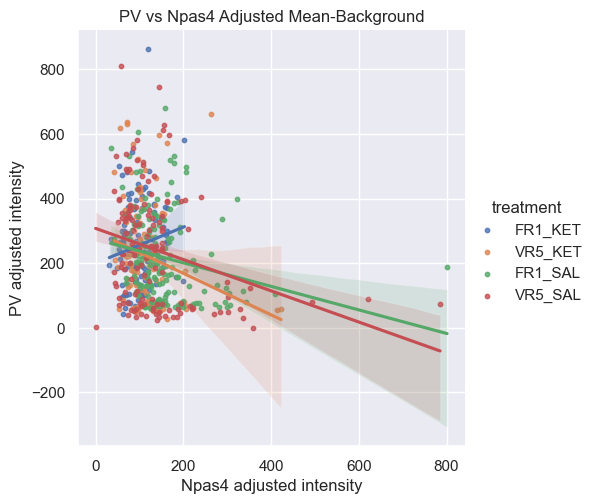

  treatment     slope   intercept   r_value   p_value   std_err sig
0   FR1_KET  0.559128  199.973456  0.151455  0.121192  0.357826    
1   VR5_KET -0.641751  296.879457 -0.217675  0.023634  0.279488   *
2   FR1_SAL -0.364336  274.004982 -0.217508  0.005010  0.128059   *
3   VR5_SAL -0.483018  307.679166 -0.281577  0.000718  0.139612   *



======= WFA vs Npas4 Adjusted Mean-Background =======
(329, 5)


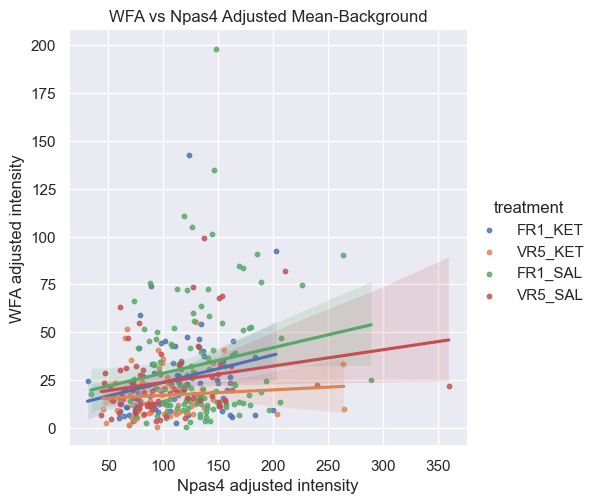

  treatment     slope  intercept   r_value   p_value   std_err sig
0   FR1_KET  0.143087   9.540406  0.249685  0.028527  0.064077   *
1   VR5_KET  0.028818  14.140091  0.096255  0.456742  0.038472    
2   FR1_SAL  0.133859  15.232910  0.166862  0.067359  0.072508    
3   VR5_SAL  0.085347  15.305821  0.224196  0.064035  0.045324    





In [16]:
from scipy import stats
def linreg(df_data, stain_X, stain_Y, query=False, title=False):
    if not query:
        q = df_data.query(f'dummy_{stain_X} == {True} and dummy_{stain_Y} == {True}\
                           and (stain_type == "{stain_X}" or stain_type == "{stain_Y}")')
    elif query:
        q = df_data.query(query)
        
    df_X = q.query(f'stain_type == "{stain_X}"')[
        ['image_name', 'true_grouping', 'treatment', 'adjusted_mean-background']
        ].rename(columns={'adjusted_mean-background': f'{stain_X} adjusted intensity'})
    df_Y = q.query(f'stain_type == "{stain_Y}"')[
        ['image_name', 'true_grouping', 'treatment', 'adjusted_mean-background']
        ].rename(columns={'adjusted_mean-background': f'{stain_Y} adjusted intensity'})

    df_X['id'] = list(zip(df_X.image_name.values, df_X.true_grouping.values))
    df_Y['id'] = list(zip(df_Y.image_name.values, df_Y.true_grouping.values))

    df_X = df_X.drop(['image_name', 'true_grouping'], axis=1)
    df_Y = df_Y.drop(['image_name', 'true_grouping'], axis=1)

    df_merge = df_X.merge(df_Y, on='id').rename(columns={'treatment_x': 'treatment'})
    print(f'======= {stain_Y} vs {stain_X} Adjusted Mean-Background =======')
    print(df_merge.shape)

    #sns.set_theme()
    #sns.scatterplot(x=f'{stain_X} adjusted intensity', y=f'{stain_Y} adjusted intensity', hue='treatment', data=df_merge, s=20)
    #plt.title(f'{stain_Y} vs {stain_X} Adjusted Mean-Background')
    #plt.show()

    sns.lmplot(x=f'{stain_X} adjusted intensity', y=f'{stain_Y} adjusted intensity',\
               hue='treatment', data=df_merge, scatter_kws={"s": 10})
    
    if not title:
        plt.title(f'{stain_Y} vs {stain_X} Adjusted Mean-Background')
    elif title:
        plt.title(title)
    plt.show()

    model_summary = []
    for treatment in df_merge.treatment.unique():
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            df_merge.query(f'treatment == "{treatment}"')[f'{stain_X} adjusted intensity'], \
            df_merge.query(f'treatment == "{treatment}"')[f'{stain_Y} adjusted intensity']
            )

        row = dict(zip(['treatment', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'], \
                       [treatment, slope, intercept, r_value, p_value, std_err]
                       ))
        model_summary.append(row)

    model_summary = pd.DataFrame(model_summary)
    model_summary['sig'] = model_summary.p_value.apply(lambda x: '*' if x <= 0.05 else ' ')
    print(model_summary)
    print('\n\n')

    return model_summary

PV_WFA_lr = linreg(df_coloc, 'PV', 'WFA')
cFos_PV_lr = linreg(df_coloc, 'cFos', 'PV')
cFos_WFA_lr = linreg(df_coloc, 'cFos', 'WFA')
Npas4_cFos_lr = linreg(df_coloc, 'Npas4', 'cFos')
Npas4_PV_lr = linreg(df_coloc, 'Npas4', 'PV')
Npas4_WFA_lr = linreg(df_coloc, 'Npas4', 'WFA')

# Linear regressors, with vs without WFA/PV

## Npas4/WFA/PV±, Npas4/PV/WFA±

======= WFA vs Npas4 Adjusted Mean-Background =======
(252, 5)


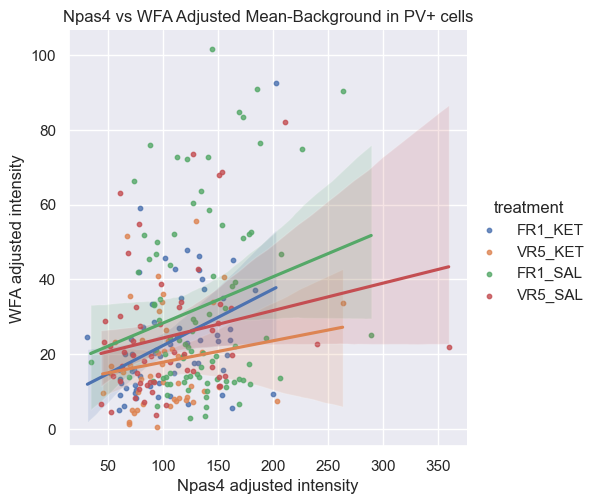

  treatment     slope  intercept   r_value   p_value   std_err sig
0   FR1_KET  0.150625   7.273494  0.373519  0.003286  0.049118   *
1   VR5_KET  0.057226  12.146121  0.169561  0.249257  0.049041    
2   FR1_SAL  0.123735  15.966597  0.209585  0.051379  0.062613    
3   VR5_SAL  0.073302  17.005531  0.220660  0.099058  0.043689    



======= WFA vs Npas4 Adjusted Mean-Background =======
(77, 5)


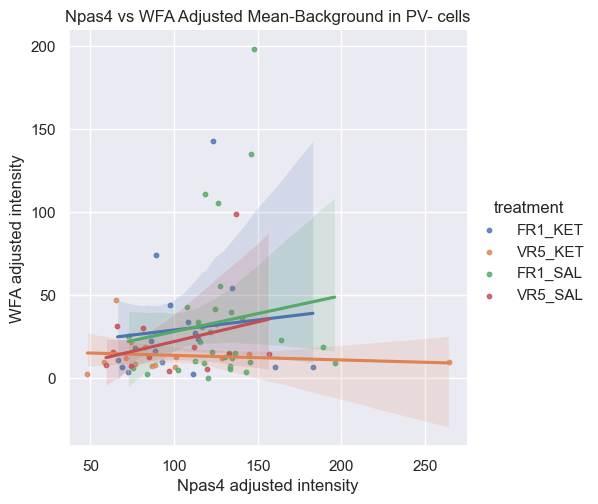

  treatment     slope  intercept   r_value   p_value   std_err sig
0   FR1_KET  0.121154  16.953997  0.110167  0.673816  0.282221    
1   VR5_KET -0.027756  16.614326 -0.139202  0.635066  0.056999    
2   FR1_SAL  0.216255   6.474956  0.137212  0.439036  0.275976    
3   VR5_SAL  0.237029  -1.564525  0.297340  0.347944  0.240684    



======= PV vs Npas4 Adjusted Mean-Background =======
(252, 5)


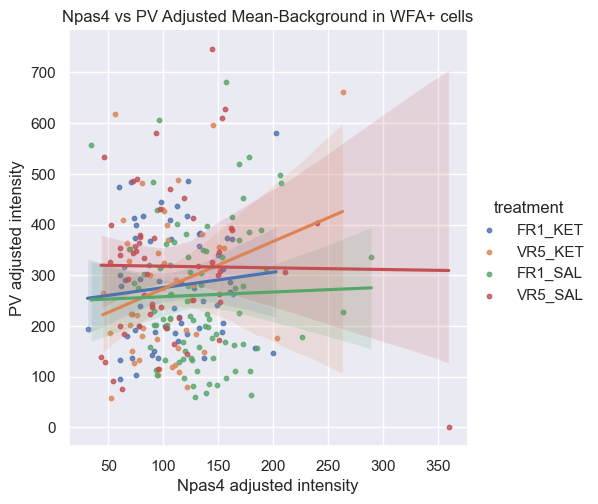

  treatment     slope   intercept   r_value   p_value   std_err sig
0   FR1_KET  0.304920  244.969752  0.104585  0.426467  0.380729    
1   VR5_KET  0.934144  179.953898  0.252105  0.083874  0.528682    
2   FR1_SAL  0.092614  248.317252  0.028293  0.794759  0.354905    
3   VR5_SAL -0.032635  321.073523 -0.012251  0.927934  0.359174    



======= PV vs Npas4 Adjusted Mean-Background =======
(268, 5)


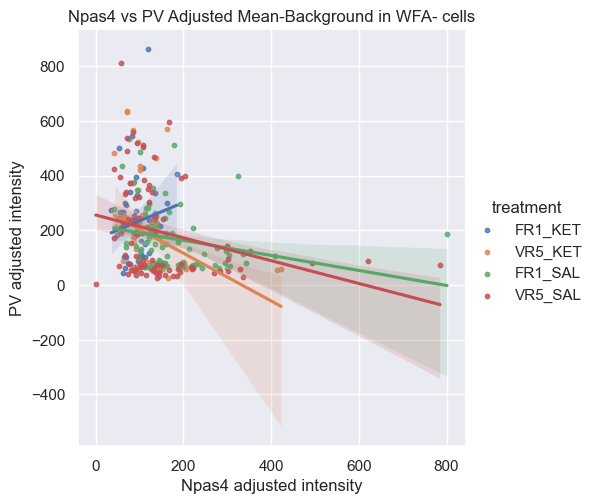

  treatment     slope   intercept   r_value   p_value   std_err sig
0   FR1_KET  0.673723  166.848295  0.132287  0.380824  0.761036    
1   VR5_KET -0.873344  290.736452 -0.333262  0.009269  0.324430   *
2   FR1_SAL -0.274339  217.538586 -0.245075  0.030572  0.124489   *
3   VR5_SAL -0.417038  255.567113 -0.288200  0.007849  0.153019   *





In [17]:
q = 'dummy_Npas4 == True and dummy_WFA == True and dummy_PV == True and (stain_type == "Npas4" or stain_type == "WFA")'
t = 'Npas4 vs WFA Adjusted Mean-Background in PV+ cells'
Npas4_WFA_PV_lr = linreg(df_coloc, 'Npas4', 'WFA', query=q, title=t)

q = 'dummy_Npas4 == True and dummy_WFA == True and dummy_PV == False and (stain_type == "Npas4" or stain_type == "WFA")'
t = 'Npas4 vs WFA Adjusted Mean-Background in PV- cells'
Npas4_WFA_PV_lr = linreg(df_coloc, 'Npas4', 'WFA', query=q, title=t)

q = 'dummy_Npas4 == True and dummy_WFA == True and dummy_PV == True and (stain_type == "Npas4" or stain_type == "PV")'
t = 'Npas4 vs PV Adjusted Mean-Background in WFA+ cells'
Npas4_WFA_PV_lr = linreg(df_coloc, 'Npas4', 'PV', query=q, title=t)

q = 'dummy_Npas4 == True and dummy_WFA == False and dummy_PV == True and (stain_type == "Npas4" or stain_type == "PV")'
t = 'Npas4 vs PV Adjusted Mean-Background in WFA- cells'
Npas4_WFA_PV_lr = linreg(df_coloc, 'Npas4', 'PV', query=q, title=t)

## cFos/WFA/PV±, cFos/PV/WFA±

======= WFA vs cFos Adjusted Mean-Background =======
(270, 5)


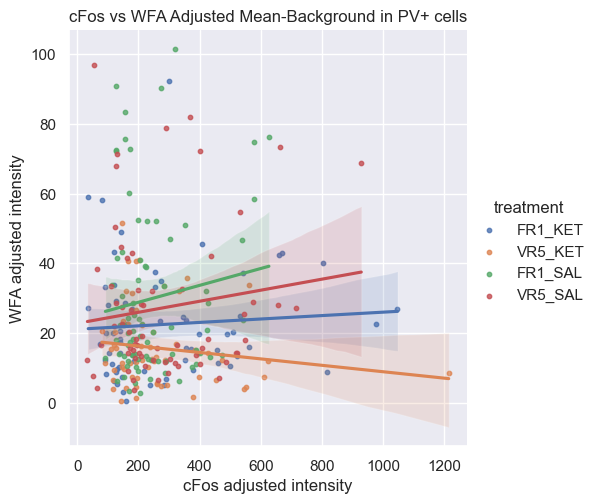

  treatment     slope  intercept   r_value   p_value   std_err sig
0   FR1_KET  0.004908  21.109230  0.069780  0.583757  0.008911    
1   VR5_KET -0.009219  18.132643 -0.146620  0.263621  0.008167    
2   FR1_SAL  0.024232  24.016689  0.122958  0.280339  0.022289    
3   VR5_SAL  0.015850  22.813099  0.133591  0.281145  0.014584    



======= WFA vs cFos Adjusted Mean-Background =======
(143, 5)


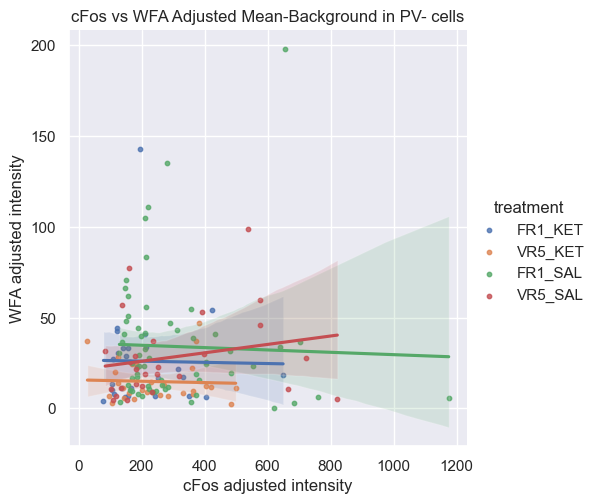

  treatment     slope  intercept   r_value   p_value   std_err sig
0   FR1_KET -0.003279  26.689189 -0.015544  0.939922  0.043052    
1   VR5_KET -0.003704  15.712138 -0.042049  0.828538  0.016938    
2   FR1_SAL -0.006481  36.101389 -0.037010  0.777046  0.022783    
3   VR5_SAL  0.023177  21.349538  0.206591  0.301188  0.021954    



======= PV vs cFos Adjusted Mean-Background =======
(270, 5)


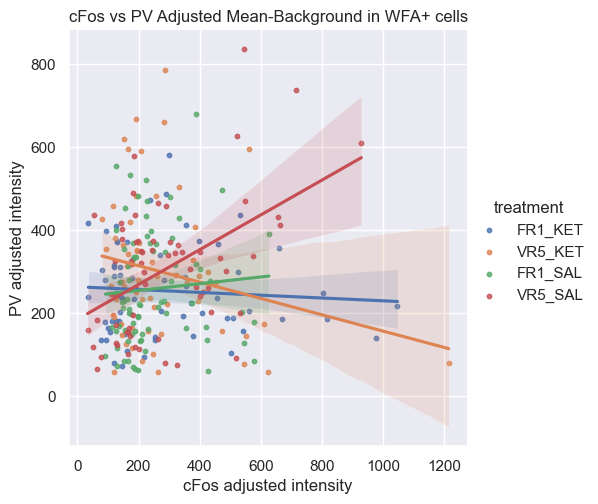

  treatment     slope   intercept   r_value   p_value   std_err sig
0   FR1_KET -0.033753  263.883165 -0.070838  0.578053  0.060362    
1   VR5_KET -0.196809  353.899768 -0.212388  0.103273  0.118899    
2   FR1_SAL  0.081465  238.748151  0.072805  0.523712  0.127179    
3   VR5_SAL  0.419324  185.546664  0.480330  0.000039  0.094972   *



======= PV vs cFos Adjusted Mean-Background =======
(302, 5)


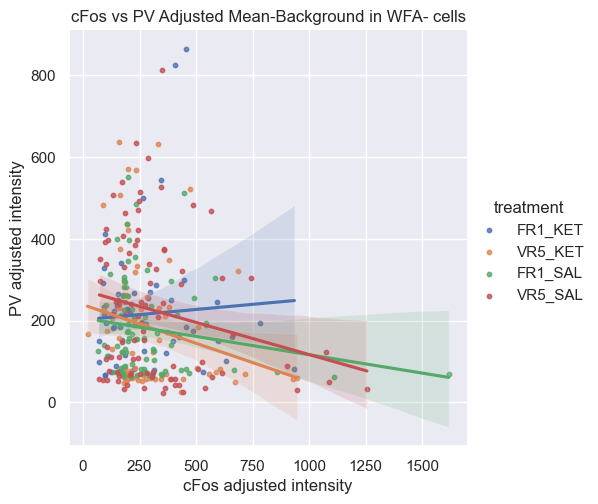

  treatment     slope   intercept   r_value   p_value   std_err sig
0   FR1_KET  0.050134  202.005515  0.061041  0.654944  0.111559    
1   VR5_KET -0.188222  238.655500 -0.212241  0.079979  0.105876    
2   FR1_SAL -0.089540  206.160806 -0.171376  0.110377  0.055506    
3   VR5_SAL -0.156794  273.879801 -0.207189  0.051393  0.079374    





In [18]:
q = 'dummy_cFos == True and dummy_WFA == True and dummy_PV == True and (stain_type == "cFos" or stain_type == "WFA")'
t = 'cFos vs WFA Adjusted Mean-Background in PV+ cells'
cFos_WFA_PV_lr = linreg(df_coloc, 'cFos', 'WFA', query=q, title=t)

q = 'dummy_cFos == True and dummy_WFA == True and dummy_PV == False and (stain_type == "cFos" or stain_type == "WFA")'
t = 'cFos vs WFA Adjusted Mean-Background in PV- cells'
cFos_WFA_PV_lr = linreg(df_coloc, 'cFos', 'WFA', query=q, title=t)

q = 'dummy_cFos == True and dummy_WFA == True and dummy_PV == True and (stain_type == "cFos" or stain_type == "PV")'
t = 'cFos vs PV Adjusted Mean-Background in WFA+ cells'
cFos_WFA_PV_lr = linreg(df_coloc, 'cFos', 'PV', query=q, title=t)

q = 'dummy_cFos == True and dummy_WFA == False and dummy_PV == True and (stain_type == "cFos" or stain_type == "PV")'
t = 'cFos vs PV Adjusted Mean-Background in WFA- cells'
cFos_WFA_PV_lr = linreg(df_coloc, 'cFos', 'PV', query=q, title=t)

# Some barplots and ANOVA
## Is adjusted WFA intensity different in PV vs Non-PV cells across treatments?
No, but there is a simple main effect of treatment, react and PV (+/-) (that is, each effect does not depend on the level of another)

,sum_sq,df,F,PR(>F),sig
C(treat),10.011418,1.0,18.281991,0.000021,*
C(react),7.583969,1.0,13.849192,0.000210,*
C(dummy_PV),5.211453,1.0,9.516708,0.002099,*
C(treat):C(react),0.771682,1.0,1.409180,0.235508,--
C(react):C(dummy_PV),0.762402,1.0,1.392234,0.238342,--
C(dummy_PV):C(treat),0.559290,1.0,1.021328,0.312477,--
C(treat):C(react):C(dummy_PV),0.566196,1.0,1.033939,0.309510,--
Residual,490.111777,895.0,NaN,NaN,--


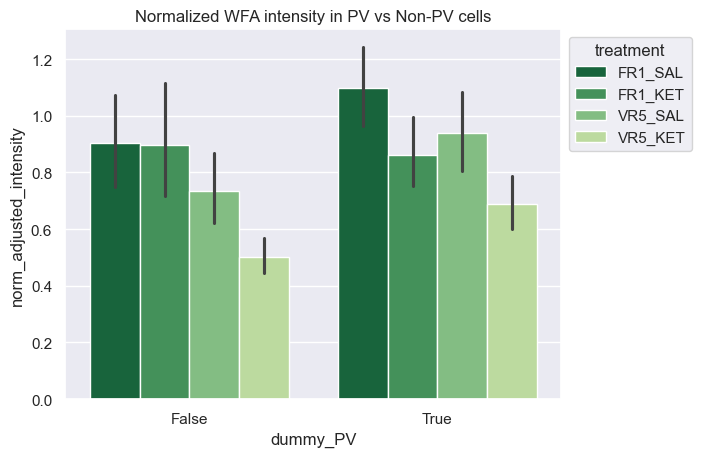

In [19]:
def plot_single_intensity_excl(target_stain, excl_stain):
    # load in normalized data
    df = pd.read_csv(f'NORM/KET-VR5_single_{target_stain}_NORM.csv')

    # sort
    sort_order = {'FR1_SAL': 0, 'FR1_KET': 1, 'VR5_SAL': 2, 'VR5_KET':3}
    df = df.sort_values(by='treatment', key=lambda x: x.map(sort_order))

    # query (this is redundant for single label conditions, but will be relevant later)
    q = df.query(f'stain_type == "{target_stain}"').rename(columns={'norm_adjusted_mean-background': 'norm_adjusted_intensity'}).copy().reset_index()

    # add new treatment and react cols for multi way anova
    q['treat'] = q.treatment.apply(lambda x: x.split('_')[0])
    q['react'] = q.treatment.apply(lambda x: x.split('_')[1])

    # plot
    if target_stain == 'PV':
        sns.set_palette('OrRd_r', n_colors=5)
    elif target_stain == 'WFA':
        sns.set_palette('YlGn_r', n_colors=5)
    elif target_stain == 'cFos':
        sns.set_palette('Blues_r', n_colors=5)
    elif target_stain == 'Npas4':
        sns.set_palette('Purples_r', n_colors=6)

    g =sns.barplot(x=f'dummy_{excl_stain}', y='norm_adjusted_intensity', data=q, hue='treatment')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f'Normalized {target_stain} intensity in {excl_stain} vs Non-{excl_stain} cells')

    # building model with all interaction terms
    model = ols(f'norm_adjusted_intensity ~ C(treat) + C(react) + C(dummy_{excl_stain})\
                + C(treat):C(react) + C(react):C(dummy_{excl_stain}) + C(dummy_{excl_stain}):C(treat)\
                + C(treat):C(react):C(dummy_{excl_stain})',
                data=q).fit() 

    # perform 3 way ANOVA
    result = sm.stats.anova_lm(model, typ=2) 
    result['sig'] = result['PR(>F)'].apply(lambda x: '*' if x < 0.05 else '--')
    
    return result

res = plot_single_intensity_excl('WFA', 'PV')
res

## Is adjusted PV intensity different in WFA vs Non-WFA cells across treatments?
Yes, all interaction effects are significant. Basically, a three-way interaction means that one, or more, two-way interactions differ across the levels of a third variable. Something along the lines of "the interaction effect between treatment and react depends on whether or not a WFA net was present."

,sum_sq,df,F,PR(>F),sig
C(treat),3.076091,1.0,6.013915,1.432858e-02,*
C(react),0.300993,1.0,0.588456,4.431606e-01,--
C(dummy_WFA),64.778736,1.0,126.645734,4.625165e-28,*
C(treat):C(react),1.087871,1.0,2.126844,1.449881e-01,--
C(react):C(dummy_WFA),0.075768,1.0,0.148131,7.003933e-01,--
C(dummy_WFA):C(treat),1.495760,1.0,2.924288,8.750230e-02,--
C(treat):C(react):C(dummy_WFA),0.000482,1.0,0.000941,9.755269e-01,--
Residual,643.461471,1258.0,NaN,NaN,--


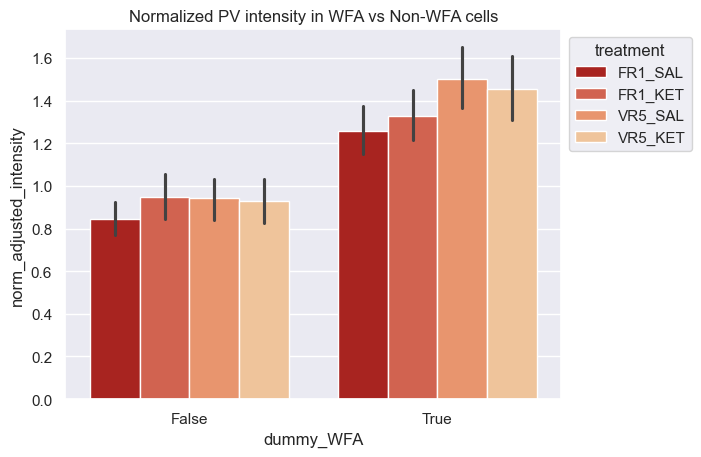

In [20]:
res = plot_single_intensity_excl('PV', 'WFA')
res

## Is adjusted Npas4 intensity different in PV vs Non-PV cells across treatments?
No, we do not have a significant three way interaction effect so in this case it would be better reduce the model and go with a 2-way ANOVA only. It looks like we will probably see a significant treatment by react effect.

,sum_sq,df,F,PR(>F),sig
C(treat),10.160476,1.0,56.408995,6.485323e-14,*
C(react),38.080491,1.0,211.415504,2.505553e-47,*
C(dummy_PV),8.962628,1.0,49.758774,1.875541e-12,*
C(treat):C(react),17.773675,1.0,98.676000,3.979993e-23,*
C(react):C(dummy_PV),2.813963,1.0,15.622576,7.795554e-05,*
C(dummy_PV):C(treat),0.040299,1.0,0.223730,6.362248e-01,--
C(treat):C(react):C(dummy_PV),0.355377,1.0,1.972984,1.601682e-01,--
Residual,1523.107945,8456.0,NaN,NaN,--


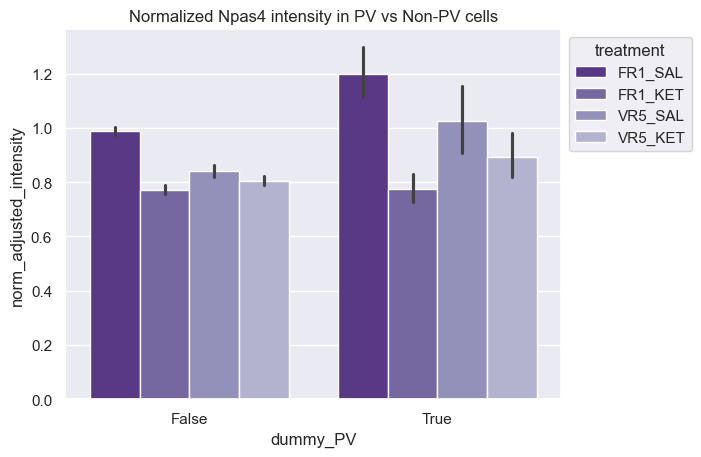

In [21]:
res = plot_single_intensity_excl('Npas4', 'PV')
res

## Is adjusted PV intensity different in Npas4 vs Non-Npas4 cells across treatments?

,sum_sq,df,F,PR(>F),sig
C(treat),2.831473,1.0,5.188609,2.290256e-02,*
C(react),0.718166,1.0,1.316023,2.515251e-01,--
C(dummy_Npas4),19.095084,1.0,34.991299,4.262923e-09,*
C(treat):C(react),0.836893,1.0,1.533588,2.158059e-01,--
C(react):C(dummy_Npas4),0.000088,1.0,0.000162,9.898419e-01,--
C(dummy_Npas4):C(treat),1.807608,1.0,3.312399,6.899658e-02,--
C(treat):C(react):C(dummy_Npas4),2.379473,1.0,4.360328,3.698592e-02,*
Residual,686.502535,1258.0,NaN,NaN,--


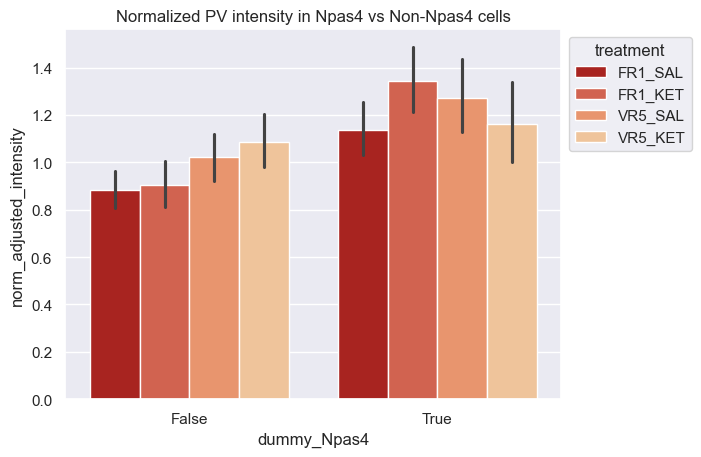

In [22]:
res = plot_single_intensity_excl('PV', 'Npas4')
res

## Is adjusted Npas4 intensity different in WFA vs Non-WFA cells across combinations of react/treatment? (NO.)


,sum_sq,df,F,PR(>F),sig
C(treat),10.111989,1.0,55.711258,9.226597e-14,*
C(react),38.153964,1.0,210.206453,4.531723e-47,*
C(dummy_WFA),0.009239,1.0,0.050903,8.215053e-01,--
C(treat):C(react),17.777461,1.0,97.943608,5.736663e-23,*
C(react):C(dummy_WFA),0.051885,1.0,0.285857,5.929022e-01,--
C(dummy_WFA):C(treat),0.369337,1.0,2.034834,1.537679e-01,--
C(treat):C(react):C(dummy_WFA),0.021615,1.0,0.119086,7.300364e-01,--
Residual,1534.824069,8456.0,NaN,NaN,--


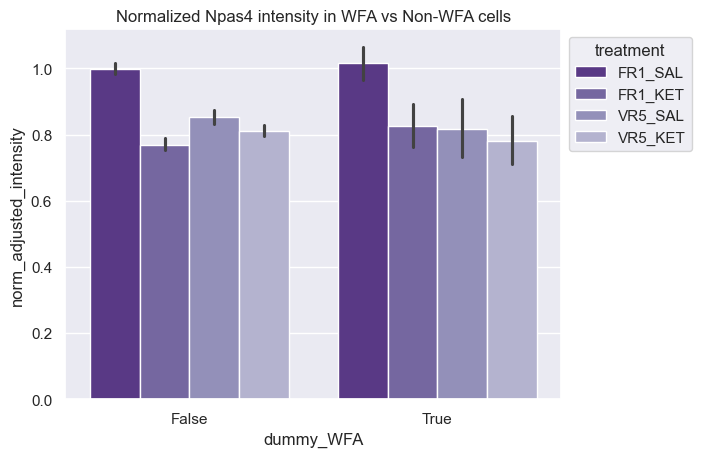

In [23]:
res = plot_single_intensity_excl('Npas4', 'WFA')
res

## Is adjusted WFA intensity different in Npas4 vs Non-Npas4 cells across combinations of react/treatment? (NO.)


,sum_sq,df,F,PR(>F),sig
C(treat),7.170440,1.0,13.286424,0.000283,*
C(react),7.153297,1.0,13.254660,0.000287,*
C(dummy_Npas4),9.061181,1.0,16.789862,0.000046,*
C(treat):C(react),1.085412,1.0,2.011208,0.156489,--
C(react):C(dummy_Npas4),1.913176,1.0,3.545008,0.060049,--
C(dummy_Npas4):C(treat),1.981805,1.0,3.672175,0.055646,--
C(treat):C(react):C(dummy_Npas4),0.863821,1.0,1.600611,0.206146,--
Residual,483.015094,895.0,NaN,NaN,--


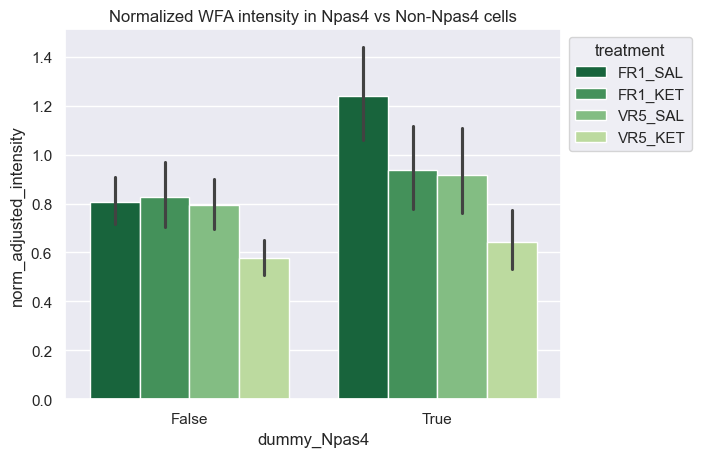

In [24]:
res = plot_single_intensity_excl('WFA', 'Npas4')
res

## Is adjusted cFos intensity different in PV vs Non-PV cells across treatments? (cFos+/PV+ vs cFos+/PV-)
No, we only see a significant 2 way interaction between treatment and reactivation that does not depend on whether or not PV was present.

,sum_sq,df,F,PR(>F),sig
C(treat),1.203329,1.0,2.155666,1.420842e-01,--
C(react),2.357885,1.0,4.223962,3.988943e-02,*
C(dummy_PV),0.256780,1.0,0.460001,4.976430e-01,--
C(treat):C(react),15.301347,1.0,27.411129,1.686696e-07,*
C(react):C(dummy_PV),0.294511,1.0,0.527593,4.676417e-01,--
C(dummy_PV):C(treat),0.395365,1.0,0.708264,4.000459e-01,--
C(treat):C(react):C(dummy_PV),0.061253,1.0,0.109730,7.404600e-01,--
Residual,4460.708750,7991.0,NaN,NaN,--


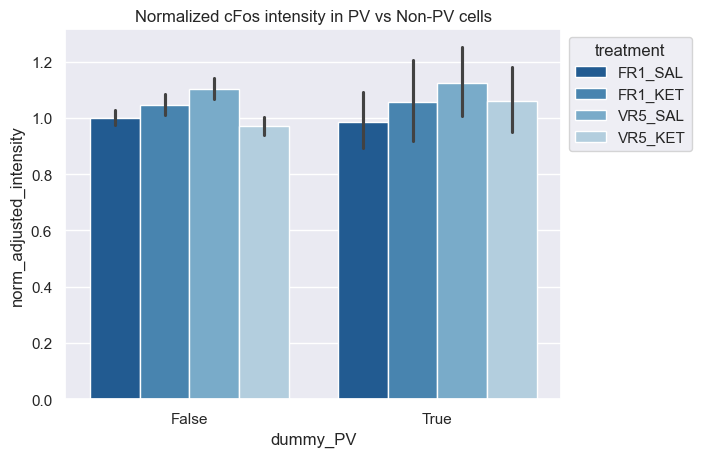

In [25]:
res = plot_single_intensity_excl('cFos', 'PV')
res

## Is adjusted PV intensity different in cFos vs Non-cFos cells across treatments?

,sum_sq,df,F,PR(>F),sig
C(treat),2.595791,1.0,4.800795,2.862951e-02,*
C(react),0.395145,1.0,0.730803,3.927859e-01,--
C(dummy_cFos),28.078262,1.0,51.929450,9.888673e-13,*
C(treat):C(react),0.797855,1.0,1.475596,2.246928e-01,--
C(react):C(dummy_cFos),0.532538,1.0,0.984905,3.211816e-01,--
C(dummy_cFos):C(treat),0.270731,1.0,0.500705,4.793217e-01,--
C(treat):C(react):C(dummy_cFos),0.725815,1.0,1.342361,2.468378e-01,--
Residual,680.200798,1258.0,NaN,NaN,--


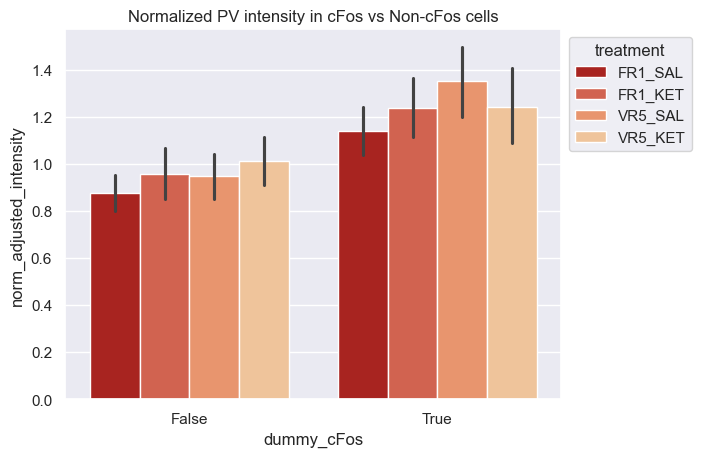

In [26]:
res = plot_single_intensity_excl('PV', 'cFos')
res

## Is adjusted cFos intensity different in WFA vs Non-WFA cells across treatments? (cFos+/WFA+ vs cFos+/WFA-)

,sum_sq,df,F,PR(>F),sig
C(treat),1.219513,1.0,2.184380,1.394566e-01,--
C(react),2.389752,1.0,4.280499,3.858411e-02,*
C(dummy_WFA),0.181171,1.0,0.324512,5.689245e-01,--
C(treat):C(react),15.248211,1.0,27.312440,1.774702e-07,*
C(react):C(dummy_WFA),0.022646,1.0,0.040563,8.403880e-01,--
C(dummy_WFA):C(treat),0.004822,1.0,0.008636,9.259602e-01,--
C(treat):C(react):C(dummy_WFA),0.250018,1.0,0.447829,5.033871e-01,--
Residual,4461.280531,7991.0,NaN,NaN,--


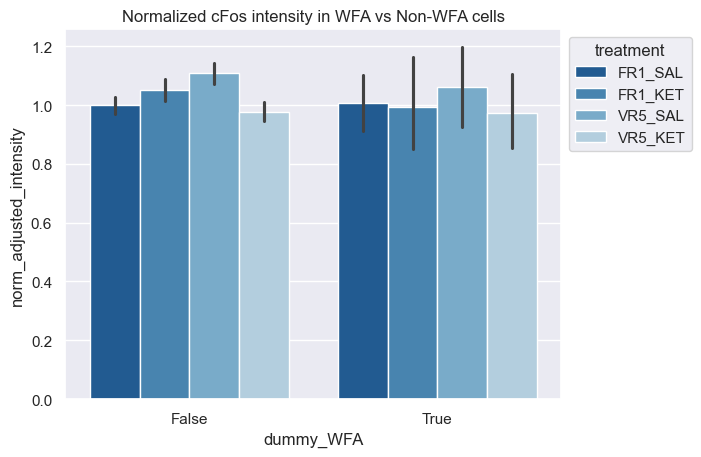

In [27]:
res = plot_single_intensity_excl('cFos', 'WFA')
res

## Is adjusted cFos intensity different in cFos vs Non-cFos cells across treatments?

,sum_sq,df,F,PR(>F),sig
C(treat),7.615981,1.0,14.217778,0.000174,*
C(react),7.530248,1.0,14.057728,0.000189,*
C(dummy_cFos),9.702642,1.0,18.113229,0.000023,*
C(treat):C(react),1.413591,1.0,2.638941,0.104625,--
C(react):C(dummy_cFos),7.565369,1.0,14.123293,0.000182,*
C(dummy_cFos):C(treat),0.225527,1.0,0.421022,0.516594,--
C(treat):C(react):C(dummy_cFos),0.007780,1.0,0.014524,0.904103,--
Residual,479.421118,895.0,NaN,NaN,--


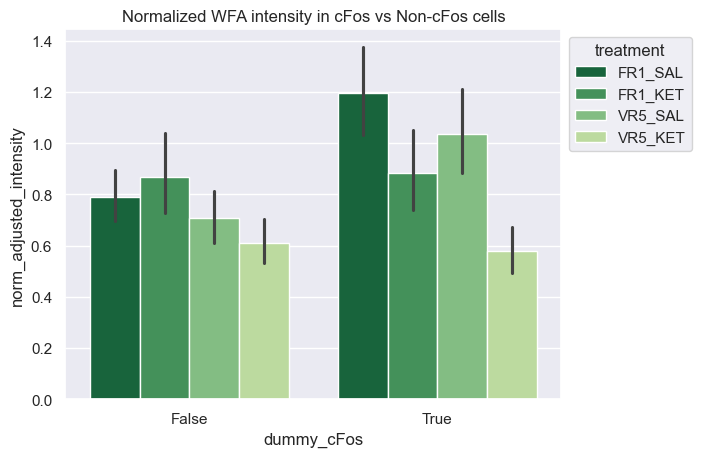

In [28]:
res = plot_single_intensity_excl('WFA', 'cFos')
res

## Is adjusted Npas4 intensity different in cFos vs Non-cFos cells across treatments?

,sum_sq,df,F,PR(>F),sig
C(treat),8.659254,1.0,51.089215,9.559809e-13,*
C(react),37.732593,1.0,222.620617,1.037037e-49,*
C(dummy_cFos),97.635329,1.0,576.044082,3.352412e-123,*
C(treat):C(react),16.146829,1.0,95.265571,2.185005e-22,*
C(react):C(dummy_cFos),0.039324,1.0,0.232009,6.300503e-01,--
C(dummy_cFos):C(treat),4.362902,1.0,25.740927,3.987634e-07,*
C(treat):C(react):C(dummy_cFos),0.021865,1.0,0.129003,7.194774e-01,--
Residual,1433.231183,8456.0,NaN,NaN,--


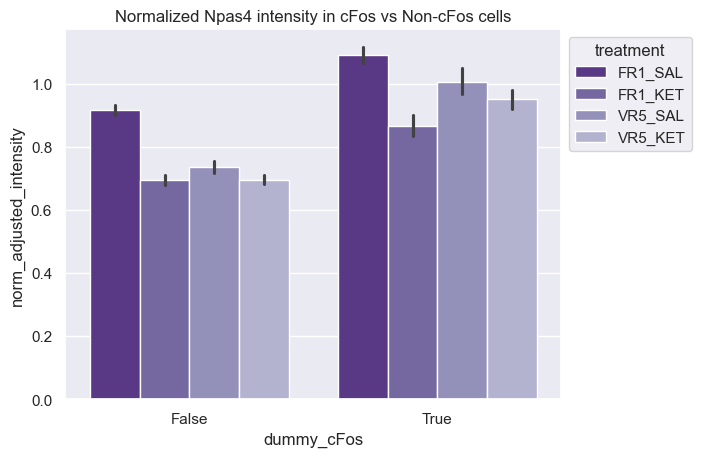

In [29]:
res = plot_single_intensity_excl('Npas4', 'cFos')
res

## Is adjusted Npas4 intensity different in cFos vs Non-cFos cells across treatments?

,sum_sq,df,F,PR(>F),sig
C(treat),0.662273,1.0,1.283771,2.572331e-01,--
C(react),0.000375,1.0,0.000726,9.784996e-01,--
C(dummy_Npas4),329.034856,1.0,637.811404,1.846148e-135,*
C(treat):C(react),22.177939,1.0,42.990408,5.842627e-11,*
C(react):C(dummy_Npas4),4.361335,1.0,8.454148,3.652140e-03,*
C(dummy_Npas4):C(treat),0.191900,1.0,0.371986,5.419412e-01,--
C(treat):C(react):C(dummy_Npas4),5.667669,1.0,10.986387,9.219219e-04,*
Residual,4122.405960,7991.0,NaN,NaN,--


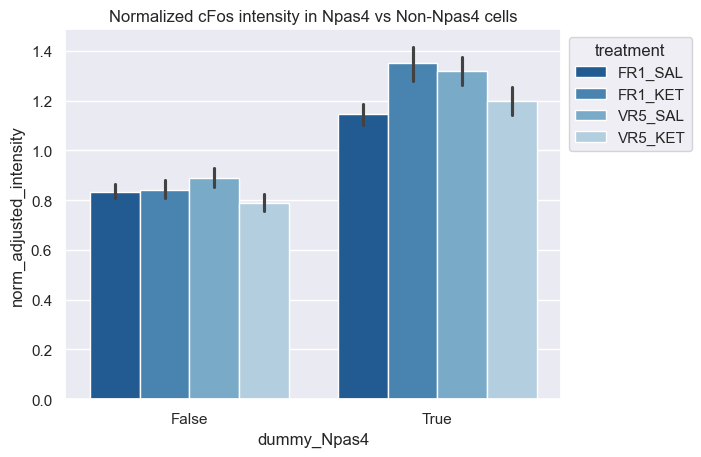

In [30]:
res = plot_single_intensity_excl('cFos', 'Npas4')
res

# Three stain type interactions (some not all)

## Is Npas4 intensity different in PV cells with or without WFA nets? 
NO

,sum_sq,df,F,PR(>F),sig
C(treat),0.558920,1.0,2.510974,1.136735e-01,--
C(react),6.553913,1.0,29.443782,8.896058e-08,*
C(dummy_WFA),3.973928,1.0,17.853069,2.825456e-05,*
C(treat):C(react),2.381897,1.0,10.700792,1.143063e-03,*
C(react):C(dummy_WFA),2.105886,1.0,9.460798,2.211300e-03,*
C(dummy_WFA):C(treat),0.357538,1.0,1.606258,2.055947e-01,--
C(treat):C(react):C(dummy_WFA),0.608226,1.0,2.732486,9.893913e-02,--
Residual,113.966462,512.0,NaN,NaN,--


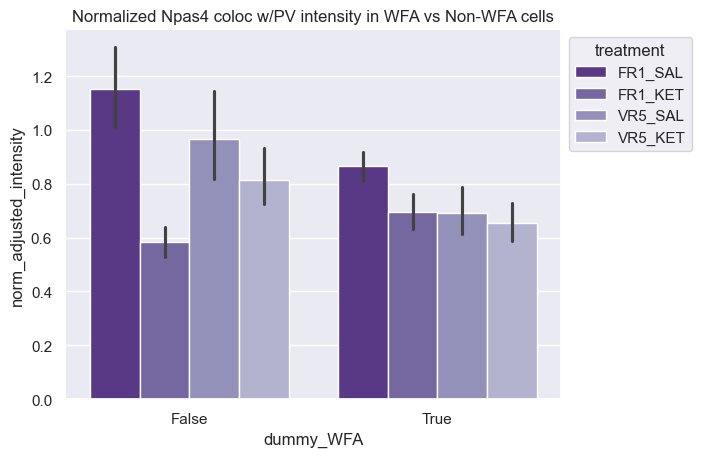

In [31]:
def plot_double_intensity_excl(target, second, excl):
    # load in normalized data
    df = pd.read_csv(f'NORM/KET-VR5_{target}_coloc_w_{second}_NORM.csv')

    # sort
    sort_order = {'FR1_SAL': 0, 'FR1_KET': 1, 'VR5_SAL': 2, 'VR5_KET':3}
    df = df.sort_values(by='treatment', key=lambda x: x.map(sort_order))

    # query (this is redundant for single label conditions, but will be relevant later)
    q = df.query(f'stain_type == "{target}"').rename(columns={'norm_adjusted_mean-background': 'norm_adjusted_intensity'}).copy().reset_index()

    # add new treatment and react cols for multi way anova
    q['treat'] = q.treatment.apply(lambda x: x.split('_')[0])
    q['react'] = q.treatment.apply(lambda x: x.split('_')[1])

    # plot
    if target == 'PV':
        sns.set_palette('OrRd_r', n_colors=5)
    elif target == 'WFA':
        sns.set_palette('YlGn_r', n_colors=5)
    elif target == 'cFos':
        sns.set_palette('Blues_r', n_colors=5)
    elif target == 'Npas4':
        sns.set_palette('Purples_r', n_colors=6)

    g =sns.barplot(x=f'dummy_{excl}', y='norm_adjusted_intensity', data=q, hue='treatment')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f'Normalized {target} coloc w/{second} intensity in {excl} vs Non-{excl} cells')

    # building model with all interaction terms
    model = ols(f'norm_adjusted_intensity ~ C(treat) + C(react) + C(dummy_{excl})\
                + C(treat):C(react) + C(react):C(dummy_{excl}) + C(dummy_{excl}):C(treat)\
                + C(treat):C(react):C(dummy_{excl})',
                data=q).fit() 

    # perform 3 way ANOVA
    result = sm.stats.anova_lm(model, typ=2) 
    result['sig'] = result['PR(>F)'].apply(lambda x: '*' if x < 0.05 else '--')
    
    return result

plot_double_intensity_excl('Npas4', 'PV', 'WFA')

## Is cFos intensity different in PV cells with or without WFA nets? 
NO

,sum_sq,df,F,PR(>F),sig
C(treat),0.829489,1.0,1.526359,0.217174,--
C(react),0.007822,1.0,0.014393,0.904549,--
C(dummy_WFA),1.265784,1.0,2.329195,0.127528,--
C(treat):C(react),0.594709,1.0,1.094336,0.295961,--
C(react):C(dummy_WFA),0.400730,1.0,0.737392,0.390862,--
C(dummy_WFA):C(treat),0.205627,1.0,0.378379,0.538720,--
C(treat):C(react):C(dummy_WFA),0.250569,1.0,0.461077,0.497400,--
Residual,306.501810,564.0,NaN,NaN,--


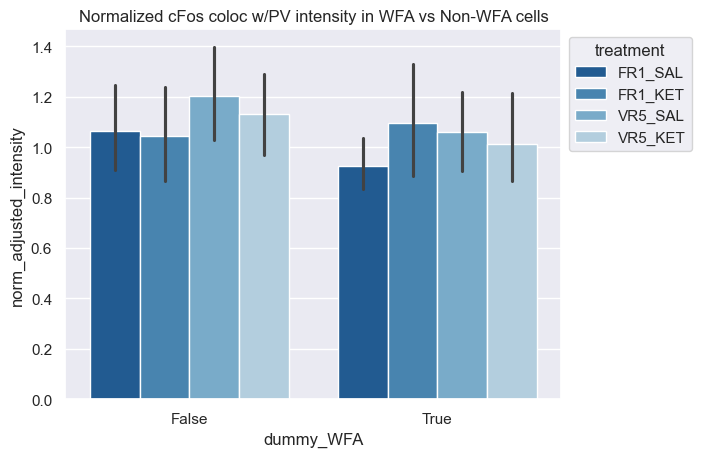

In [32]:
plot_double_intensity_excl('cFos', 'PV', 'WFA')

,sum_sq,df,F,PR(>F),sig
C(treat),2.292656,1.0,4.841259,2.819130e-02,*
C(react),0.074368,1.0,0.157038,6.920482e-01,--
C(dummy_WFA),18.978159,1.0,40.075004,4.989994e-10,*
C(treat):C(react),1.152673,1.0,2.434029,1.192883e-01,--
C(react):C(dummy_WFA),0.000713,1.0,0.001505,9.690680e-01,--
C(dummy_WFA):C(treat),1.009054,1.0,2.130756,1.449263e-01,--
C(treat):C(react):C(dummy_WFA),1.129446,1.0,2.384982,1.230672e-01,--
Residual,267.091222,564.0,NaN,NaN,--


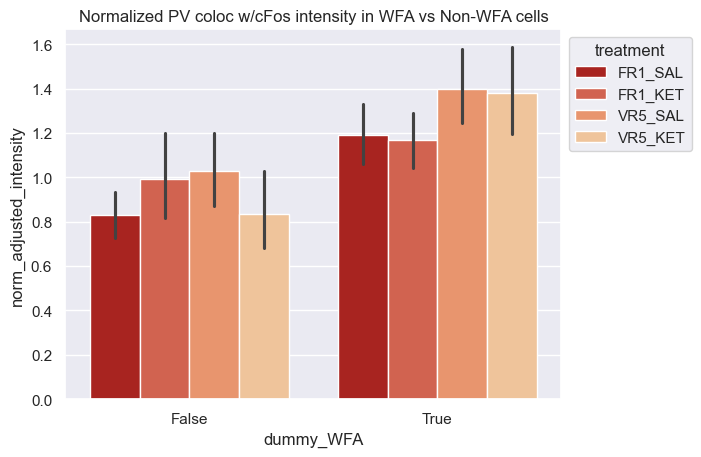

In [33]:
plot_double_intensity_excl('PV', 'cFos', 'WFA')

,sum_sq,df,F,PR(>F),sig
C(treat),0.423513,1.0,0.946726,3.310135e-01,--
C(react),0.110610,1.0,0.247258,6.192258e-01,--
C(dummy_WFA),23.609623,1.0,52.777295,1.401213e-12,*
C(treat):C(react),2.891720,1.0,6.464193,1.130035e-02,*
C(react):C(dummy_WFA),0.855027,1.0,1.911341,1.674171e-01,--
C(dummy_WFA):C(treat),0.988716,1.0,2.210191,1.377172e-01,--
C(treat):C(react):C(dummy_WFA),0.033154,1.0,0.074114,7.855484e-01,--
Residual,229.040290,512.0,NaN,NaN,--


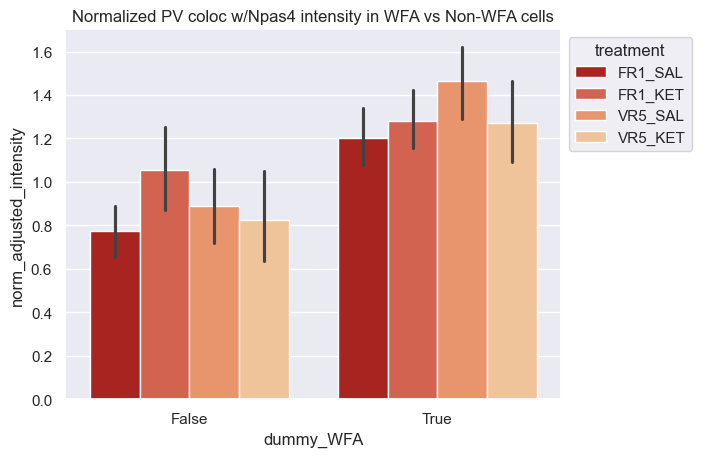

In [34]:
plot_double_intensity_excl('PV', 'Npas4', 'WFA')

,sum_sq,df,F,PR(>F),sig
C(treat),2.660709,1.0,6.914893,0.008848,*
C(react),5.434687,1.0,14.124161,0.000194,*
C(dummy_cFos),0.015933,1.0,0.041407,0.838848,--
C(treat):C(react),0.028404,1.0,0.073819,0.785983,--
C(react):C(dummy_cFos),1.795313,1.0,4.665823,0.031308,*
C(dummy_cFos):C(treat),0.002325,1.0,0.006042,0.938076,--
C(treat):C(react):C(dummy_cFos),0.539938,1.0,1.403241,0.236821,--
Residual,169.302945,440.0,NaN,NaN,--


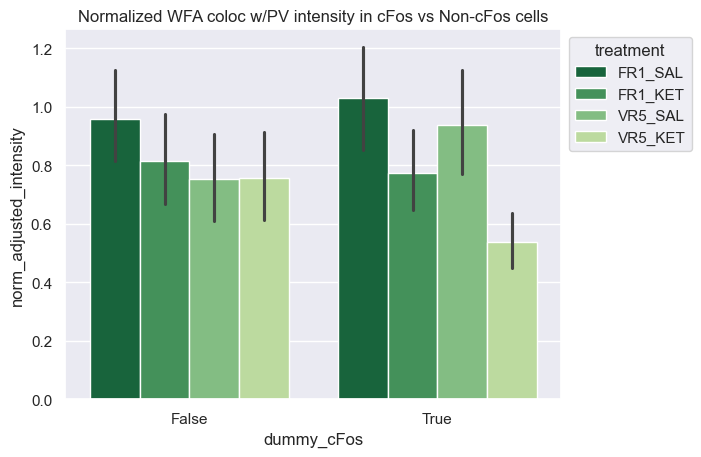

In [35]:
plot_double_intensity_excl('WFA', 'PV', 'cFos')

,sum_sq,df,F,PR(>F),sig
C(treat),1.895791,1.0,4.966957,0.026341,*
C(react),5.400427,1.0,14.149070,0.000192,*
C(dummy_Npas4),1.221337,1.0,3.199893,0.074331,--
C(treat):C(react),0.042665,1.0,0.111781,0.738285,--
C(react):C(dummy_Npas4),0.504138,1.0,1.320837,0.251066,--
C(dummy_Npas4):C(treat),1.465410,1.0,3.839361,0.050694,--
C(treat):C(react):C(dummy_Npas4),0.441537,1.0,1.156824,0.282715,--
Residual,167.939510,440.0,NaN,NaN,--


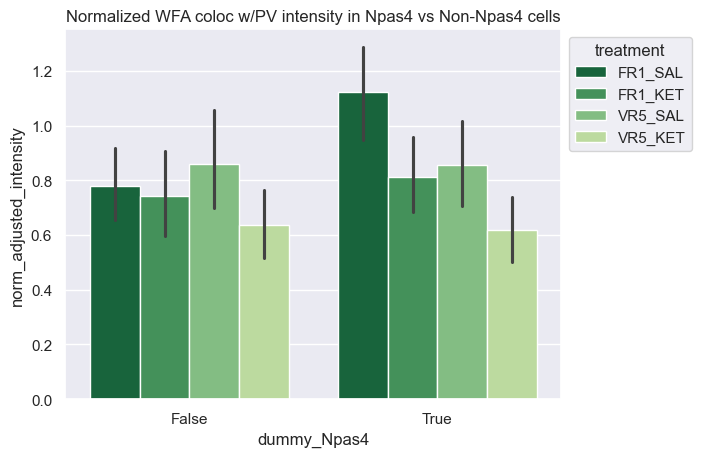

In [36]:
plot_double_intensity_excl('WFA', 'PV', 'Npas4')

# Intensity by binned cFos/Npas4

## High/Low cFos

,sum_sq,df,F,PR(>F),sig
C(treat),3.492782,1.0,6.860690,0.009142,*
C(react),9.834373,1.0,19.317146,0.000014,*
C(cFos_bin),0.241574,1.0,0.474511,0.491314,--
C(treat):C(react),0.390928,1.0,0.767880,0.381393,--
C(react):C(cFos_bin),0.621427,1.0,1.220637,0.269892,--
C(cFos_bin):C(treat),0.169184,1.0,0.332319,0.564617,--
C(treat):C(react):C(cFos_bin),0.000606,1.0,0.001190,0.972503,--
Residual,206.185784,405.0,NaN,NaN,--


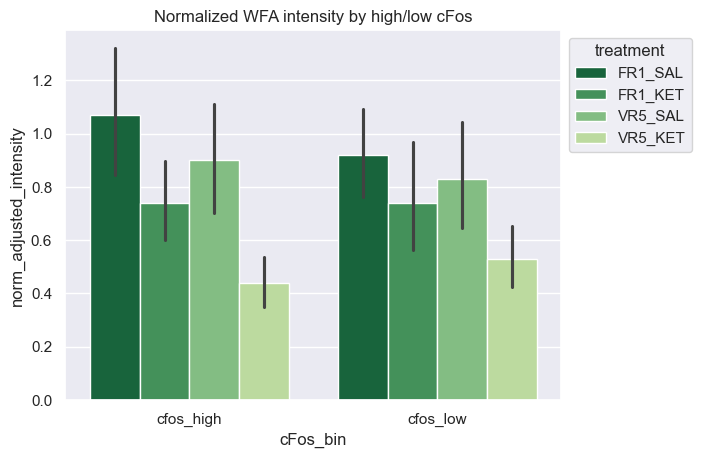

In [48]:
def plot_single_intensity_spliton(target, split_on, split_on_df):
    # load data
    df = pd.read_csv(f'NORM/KET-VR5_{target}_coloc_w_{split_on}_NORM.csv').rename(columns={'norm_adjusted_mean-background': 'norm_adjusted_intensity'})

    # sort
    sort_order = {'FR1_SAL': 0, 'FR1_KET': 1, 'VR5_SAL': 2, 'VR5_KET':3}
    df = df.sort_values(by='treatment', key=lambda x: x.map(sort_order))

    # query split_on dataframe for binned labels
    q = split_on_df.query(f'dummy_{target} == True')[['image_name', 'updated_true_grouping', 'adjusted_mean-background', f'{split_on}_bin']]\
        .reset_index()\
        .copy()\
        .rename(columns={'adjusted_mean-background':f'{split_on}_intensity'})
    df_merge = df.merge(q, on=['image_name', 'updated_true_grouping'])

    # add new treatment and react cols for multi way anova
    df_merge['treat'] = df_merge.treatment.apply(lambda x: x.split('_')[0])
    df_merge['react'] = df_merge.treatment.apply(lambda x: x.split('_')[1])
    df_merge.to_csv(f'KET-VR5_{target}_split_on_{split_on}_NORM.csv')

    # plot
    if target == 'PV':
        sns.set_palette('OrRd_r', n_colors=5)
    elif target == 'WFA':
        sns.set_palette('YlGn_r', n_colors=5)
    elif target == 'cFos':
        sns.set_palette('Blues_r', n_colors=5)
    elif target == 'Npas4':
        sns.set_palette('Purples_r', n_colors=6)

    g =sns.barplot(x=f'{split_on}_bin', y='norm_adjusted_intensity', data=df_merge, hue='treatment')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f'Normalized {target} intensity by high/low {split_on}')

    # building model with all interaction terms
    model = ols(f'norm_adjusted_intensity ~ C(treat) + C(react) + C({split_on}_bin)\
                + C(treat):C(react) + C(react):C({split_on}_bin) + C({split_on}_bin):C(treat)\
                + C(treat):C(react):C({split_on}_bin)',
                data=df_merge).fit() 

    # perform 3 way ANOVA
    result = sm.stats.anova_lm(model, typ=2) 
    result['sig'] = result['PR(>F)'].apply(lambda x: '*' if x < 0.05 else '--')

    return result


df_cfos = df_cfos.rename(columns = {'cfos_bin': 'cFos_bin'})
res = plot_single_intensity_spliton('WFA', 'cFos', df_cfos)
res

,sum_sq,df,F,PR(>F),sig
C(treat),1.516116,1.0,3.009707,0.083314,--
C(react),0.008243,1.0,0.016364,0.898256,--
C(cFos_bin),0.034864,1.0,0.069211,0.792585,--
C(treat):C(react),1.043075,1.0,2.070653,0.150712,--
C(react):C(cFos_bin),0.602369,1.0,1.195789,0.274632,--
C(cFos_bin):C(treat),0.648182,1.0,1.286734,0.257133,--
C(treat):C(react):C(cFos_bin),2.756615,1.0,5.472276,0.019669,*
Residual,284.110475,564.0,NaN,NaN,--


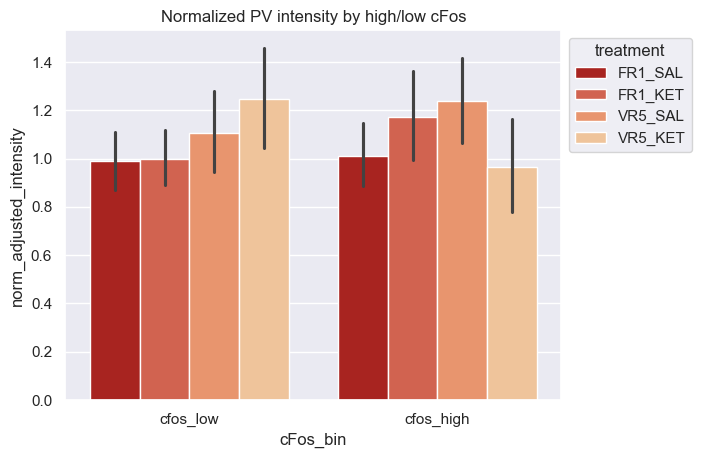

In [49]:
res = plot_single_intensity_spliton('PV', 'cFos', df_cfos)
res

,sum_sq,df,F,PR(>F),sig
C(treat),0.331914,1.0,1.519827,2.177213e-01,--
C(react),15.689346,1.0,71.841105,3.282234e-17,*
C(cFos_bin),48.756785,1.0,223.256042,4.144084e-49,*
C(treat):C(react),6.926547,1.0,31.716477,1.912041e-08,*
C(react):C(cFos_bin),0.001345,1.0,0.006159,9.374530e-01,--
C(cFos_bin):C(treat),1.020840,1.0,4.674400,3.067706e-02,*
C(treat):C(react):C(cFos_bin),0.379170,1.0,1.736209,1.876987e-01,--
Residual,837.305516,3834.0,NaN,NaN,--


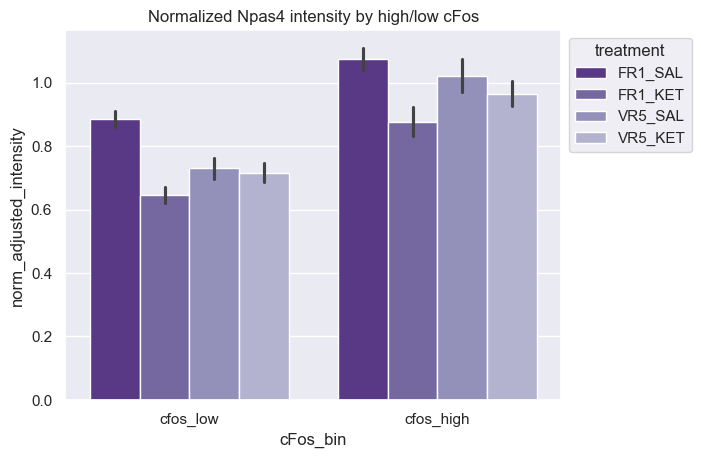

In [50]:
res = plot_single_intensity_spliton('Npas4', 'cFos', df_cfos)
res

## High/Low Npas4

,sum_sq,df,F,PR(>F),sig
C(treat),2.487977,1.0,4.946528,0.026838,*
C(react),2.687439,1.0,5.343093,0.021437,*
C(Npas4_bin),3.433559,1.0,6.826509,0.009404,*
C(treat):C(react),0.076220,1.0,0.151538,0.697328,--
C(react):C(Npas4_bin),0.211687,1.0,0.420871,0.516967,--
C(Npas4_bin):C(treat),0.107464,1.0,0.213658,0.644229,--
C(treat):C(react):C(Npas4_bin),0.830072,1.0,1.650327,0.199841,--
Residual,161.454750,321.0,NaN,NaN,--


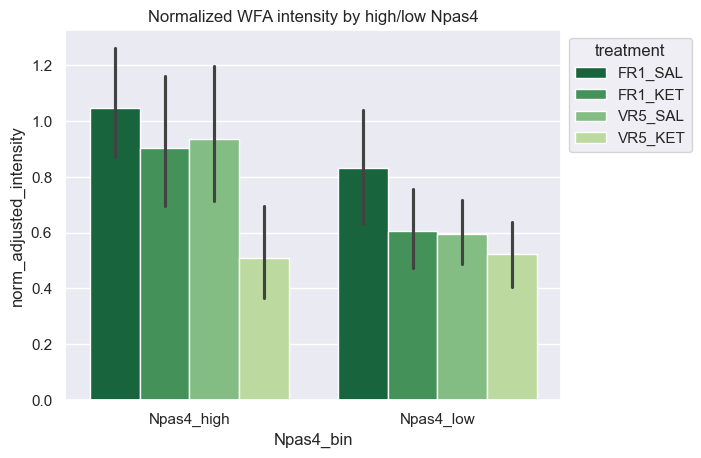

In [51]:
res = plot_single_intensity_spliton('WFA', 'Npas4', df_Npas4)
res

,sum_sq,df,F,PR(>F),sig
C(treat),0.222719,1.0,0.471712,0.492512,--
C(react),0.040470,1.0,0.085714,0.769817,--
C(Npas4_bin),4.661259,1.0,9.872390,0.001775,*
C(treat):C(react),1.750227,1.0,3.706922,0.054741,--
C(react):C(Npas4_bin),0.838817,1.0,1.776586,0.183162,--
C(Npas4_bin):C(treat),1.884381,1.0,3.991055,0.046271,*
C(treat):C(react):C(Npas4_bin),5.158983,1.0,10.926553,0.001014,*
Residual,241.741295,512.0,NaN,NaN,--


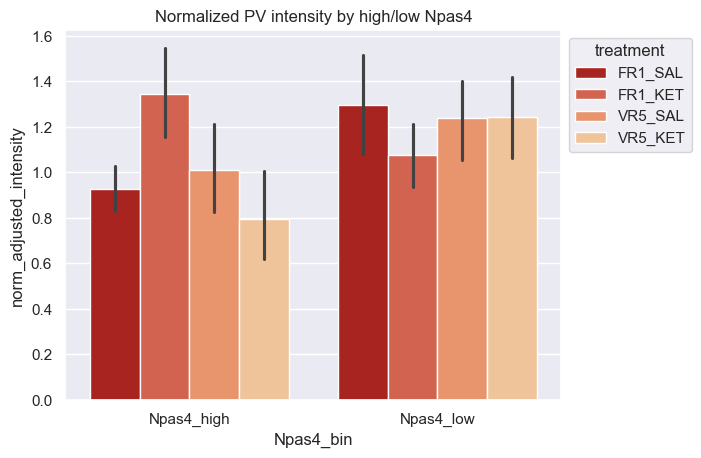

In [41]:
res = plot_single_intensity_spliton('PV', 'Npas4', df_Npas4)
res

,sum_sq,df,F,PR(>F),sig
C(treat),1.244620,1.0,2.431952,1.189673e-01,--
C(react),5.859379,1.0,11.449060,7.224788e-04,*
C(Npas4_bin),106.832141,1.0,208.746958,4.108537e-46,*
C(treat):C(react),36.045365,1.0,70.431616,6.618689e-17,*
C(react):C(Npas4_bin),5.190077,1.0,10.141263,1.461484e-03,*
C(Npas4_bin):C(treat),1.203873,1.0,2.352334,1.251781e-01,--
C(treat):C(react):C(Npas4_bin),7.389509,1.0,14.438889,1.470281e-04,*
Residual,1962.157599,3834.0,NaN,NaN,--


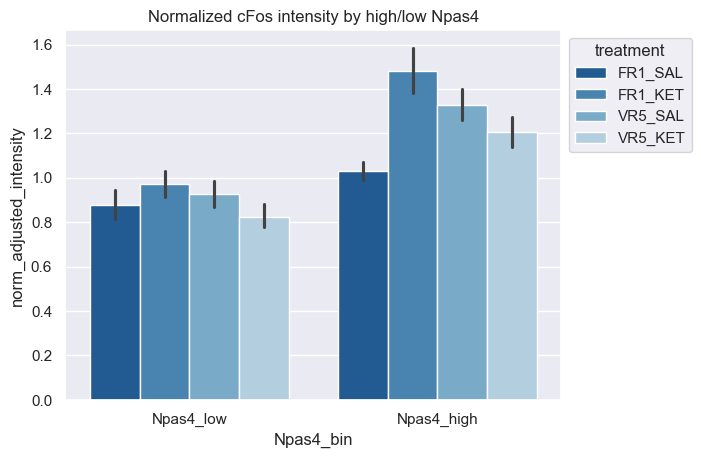

In [42]:
res = plot_single_intensity_spliton('cFos', 'Npas4', df_Npas4)
res

## Double stain types split by high/low cFos/Npas4

,sum_sq,df,F,PR(>F),sig
C(treat),1.642609,1.0,3.883241,0.049823,*
C(react),6.729150,1.0,15.908175,0.000086,*
C(cFos_bin),0.024329,1.0,0.057515,0.810654,--
C(treat):C(react),0.307921,1.0,0.727946,0.394329,--
C(react):C(cFos_bin),0.048911,1.0,0.115629,0.734097,--
C(cFos_bin):C(treat),0.416903,1.0,0.985587,0.321739,--
C(treat):C(react):C(cFos_bin),0.051641,1.0,0.122083,0.727067,--
Residual,110.825869,262.0,NaN,NaN,--


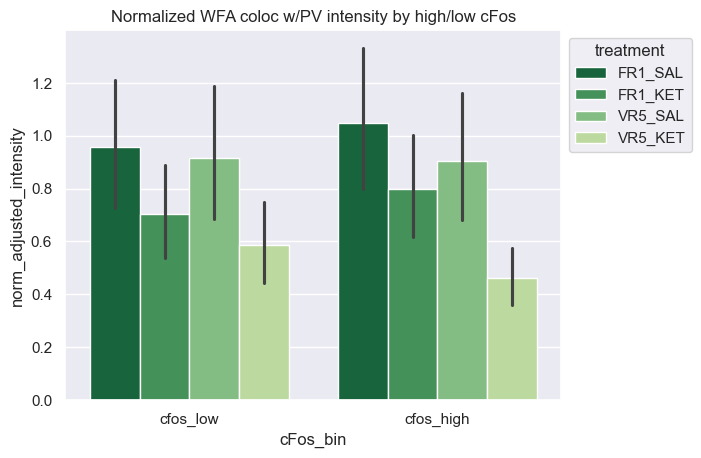

In [43]:
def plot_double_intensity_spliton(target, coloc, split_on, split_on_df):
    # load data
    try:
        df = pd.read_csv(f'NORM/KET-VR5_{target}_coloc_w_{coloc},{split_on}_NORM.csv').rename(columns={'norm_adjusted_mean-background': 'norm_adjusted_intensity'})
    except:
        df = pd.read_csv(f'NORM/KET-VR5_{target}_coloc_w_{split_on},{coloc}_NORM.csv').rename(columns={'norm_adjusted_mean-background': 'norm_adjusted_intensity'})

    # sort
    sort_order = {'FR1_SAL': 0, 'FR1_KET': 1, 'VR5_SAL': 2, 'VR5_KET':3}
    df = df.sort_values(by='treatment', key=lambda x: x.map(sort_order))

    # query split_on dataframe for binned labels
    q = split_on_df.query(f'dummy_{target} == True')[['image_name', 'updated_true_grouping', f'{split_on}_bin']].reset_index().copy()
    df_merge = df.merge(q, on=['image_name', 'updated_true_grouping'])

    # add new treatment and react cols for multi way anova
    df_merge['treat'] = df_merge.treatment.apply(lambda x: x.split('_')[0])
    df_merge['react'] = df_merge.treatment.apply(lambda x: x.split('_')[1])
    df_merge.to_csv(f'KET-VR5_{target}')

    # plot
    if target == 'PV':
        sns.set_palette('OrRd_r', n_colors=5)
    elif target == 'WFA':
        sns.set_palette('YlGn_r', n_colors=5)
    elif target == 'cFos':
        sns.set_palette('Blues_r', n_colors=5)
    elif target == 'Npas4':
        sns.set_palette('Purples_r', n_colors=6)

    g =sns.barplot(x=f'{split_on}_bin', y='norm_adjusted_intensity', data=df_merge, hue='treatment')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f'Normalized {target} coloc w/{coloc} intensity by high/low {split_on}')

    # building model with all interaction terms
    model = ols(f'norm_adjusted_intensity ~ C(treat) + C(react) + C({split_on}_bin)\
                + C(treat):C(react) + C(react):C({split_on}_bin) + C({split_on}_bin):C(treat)\
                + C(treat):C(react):C({split_on}_bin)',
                data=df_merge).fit() 

    # perform 3 way ANOVA
    result = sm.stats.anova_lm(model, typ=2) 
    result['sig'] = result['PR(>F)'].apply(lambda x: '*' if x < 0.05 else '--')

    return result

res = plot_double_intensity_spliton('WFA', 'PV', 'cFos', df_cfos)
res

,sum_sq,df,F,PR(>F),sig
C(treat),1.864587,1.0,6.136997,0.013869,*
C(react),0.021513,1.0,0.070807,0.790375,--
C(cFos_bin),1.422814,1.0,4.682970,0.031367,*
C(treat):C(react),0.011667,1.0,0.038400,0.844793,--
C(react):C(cFos_bin),1.894376,1.0,6.235044,0.013139,*
C(cFos_bin):C(treat),0.003471,1.0,0.011425,0.914960,--
C(treat):C(react):C(cFos_bin),0.465102,1.0,1.530810,0.217099,--
Residual,79.602740,262.0,NaN,NaN,--


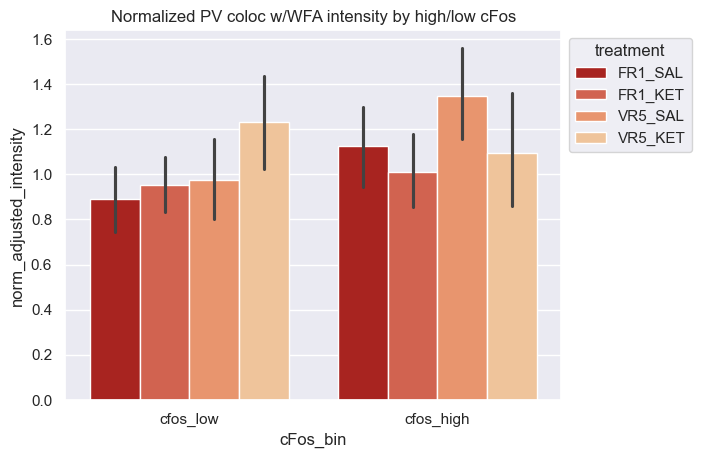

In [44]:
res = plot_double_intensity_spliton('PV', 'WFA', 'cFos', df_cfos)
res

,sum_sq,df,F,PR(>F),sig
C(treat),1.553348,1.0,4.569871,0.033533,*
C(react),2.969992,1.0,8.737568,0.003423,*
C(Npas4_bin),1.530991,1.0,4.504098,0.034821,*
C(treat):C(react),0.004435,1.0,0.013047,0.909153,--
C(react):C(Npas4_bin),0.033582,1.0,0.098798,0.753546,--
C(Npas4_bin):C(treat),0.000479,1.0,0.001411,0.970071,--
C(treat):C(react):C(Npas4_bin),1.022861,1.0,3.009204,0.084056,--
Residual,82.938201,244.0,NaN,NaN,--


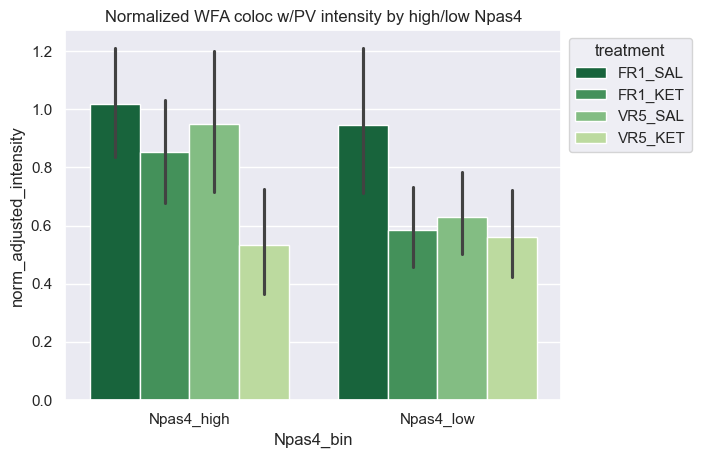

In [45]:
res = plot_double_intensity_spliton('WFA', 'PV', 'Npas4', df_Npas4)
res

,sum_sq,df,F,PR(>F),sig
C(treat),0.744219,1.0,2.807101,0.095129,--
C(react),0.072736,1.0,0.274352,0.600903,--
C(Npas4_bin),0.024956,1.0,0.094131,0.759251,--
C(treat):C(react),0.602156,1.0,2.271258,0.133086,--
C(react):C(Npas4_bin),0.039852,1.0,0.150318,0.698570,--
C(Npas4_bin):C(treat),0.110365,1.0,0.416284,0.519404,--
C(treat):C(react):C(Npas4_bin),0.589423,1.0,2.223231,0.137240,--
Residual,64.689295,244.0,NaN,NaN,--


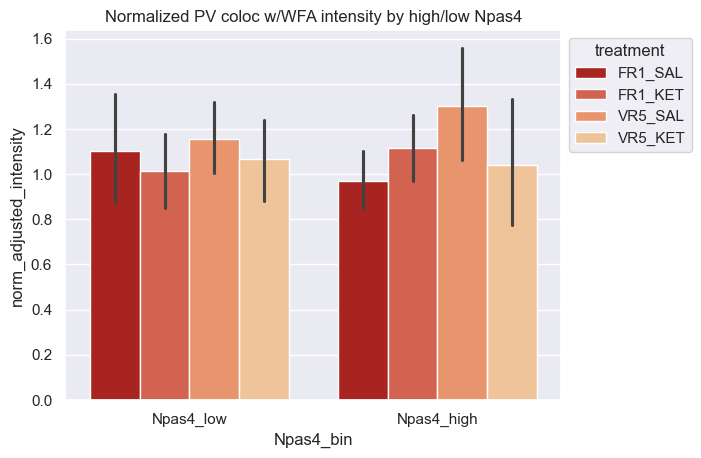

In [46]:
res = plot_double_intensity_spliton('PV', 'WFA', 'Npas4', df_Npas4)
res